# Requirements

## <span style='font-family:"Times New Roman"'>The scripts are implemented using *Python 3.7.1* with the help of the following packages:


*numpy 1.17.4*

*opencv 4.1.2*

*openpyxl 3.0.4*

*scikit-learn 0.22.1*

*matplotlib 3.0.1*

*SciPy 1.5.2*

*scikit-image 0.15.0*


# 1. Reading Tracking Results

## 1.1 Reading center

In [1]:
import numpy as np
path = ''
center_path = path + 'centers.txt'
center_y = np.loadtxt(center_path)[1] # row number
center_x = np.loadtxt(center_path)[0] # column number

## 1.2 Reading bounding boxes

In [2]:
import cv2 as cv

from openpyxl import Workbook
from openpyxl import load_workbook

xls_path = path + 'tracking_results.xlsx'

#tracking_min = 3 # the minimum number of frames that a blob is tracked through
tracking_max = 10000 # the frame number 

wb = load_workbook(xls_path)
sheet = wb['tracking']
tracking_number = []

row_number = 0
col_number = 0

bboxes = []
frames = []
frame_start = -1

count = 0

for row in sheet.values:
    bbox = []
    count = 0
    frame_start = -1
    if row_number == 0:
        row_number = row_number + 1
        continue
    for value in row:
        if col_number == 0:
            col_number = col_number + 1
            continue
        if col_number > tracking_max:
            if frame_start == -1:
                break
            else:
                frame_end = col_number - 1
                start = frame_start
                end = frame_end
                frame_start = -1
                break
        if col_number > 0 and value is not None:            
            if frame_start == -1:
                frame_start = col_number - 1
            frame_end = col_number
            bbox.append(value)
        else:
            if frame_start > 0:
                break
        col_number = col_number + 1
    if len(bbox)>0:
        bboxes.append(bbox)
        frames.append([frame_start,frame_end])
    row_number = row_number + 1
    col_number = 0
    if row_number>0 and row_number%100==0:
        print("{} rows processed".format(row_number))

100 rows processed
200 rows processed
300 rows processed
400 rows processed
500 rows processed
600 rows processed
700 rows processed
800 rows processed
900 rows processed
1000 rows processed
1100 rows processed
1200 rows processed
1300 rows processed
1400 rows processed
1500 rows processed
1600 rows processed
1700 rows processed
1800 rows processed
1900 rows processed
2000 rows processed
2100 rows processed
2200 rows processed
2300 rows processed
2400 rows processed
2500 rows processed
2600 rows processed
2700 rows processed
2800 rows processed
2900 rows processed
3000 rows processed
3100 rows processed
3200 rows processed
3300 rows processed
3400 rows processed
3500 rows processed
3600 rows processed
3700 rows processed
3800 rows processed
3900 rows processed
4000 rows processed
4100 rows processed
4200 rows processed
4300 rows processed
4400 rows processed
4500 rows processed
4600 rows processed
4700 rows processed
4800 rows processed
4900 rows processed
5000 rows processed
5100 rows

## 1.3 Reading the video 

In [3]:
video_path = ''
cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
#fourcc = cv.VideoWriter_fourcc(*'XVID')

images = []
success, frame = cap.read()   
count = 0
while success:
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    images.append(frame)
    success, frame = cap.read()
cap.release()

In [4]:
len(images)

393

# 2. Center Determination

In [5]:
import os
import sys
def mean_image_from_video(video, bar_regions = None):
    if not os.path.exists(video):
        print("Error: {} does not exist".format(video))
        sys.exit(2)
    cap = cv.VideoCapture(video)

    fps = cap.get(cv.CAP_PROP_FPS)

    H,W = (int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)),
        int(cap.get(cv.CAP_PROP_FRAME_WIDTH)))
    mean = np.zeros((H, W))
    success, frame = cap.read()   
    count = 0
    while success:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        if bar_regions is not None:
            for region in bar_regions:
                h1,w1,h2,w2 = region
                frame[h1:h2,w1:w2] = 0
        mean = mean + frame
        success, frame = cap.read()
        count = count + 1
    cap.release()
    mean = mean/count
    return mean

## 2.1 GMM results

In [19]:
from sklearn.mixture import GaussianMixture
input_video = video_path
bar_region = (470,2,504,79)
regions = []
mean_img = mean_image_from_video(input_video,regions)
gmm = GaussianMixture(
        n_components=10, max_iter=20000).fit(mean_img.reshape(-1,1))

In [20]:
mean_ind = np.argsort(gmm.means_[:, 0])[::-1]

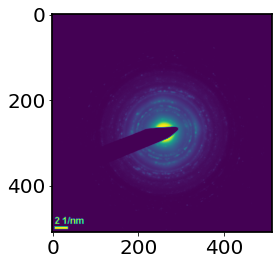

In [14]:
import matplotlib.pyplot as plt
plt.imshow(mean_img)

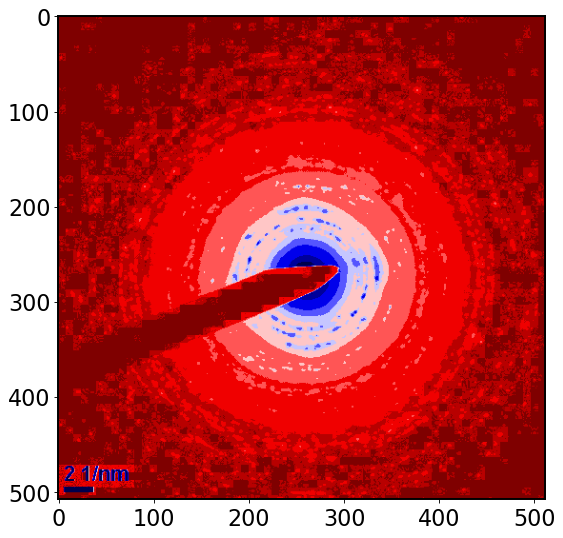

In [23]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
components = 10
plasma = cm.get_cmap('seismic', components)
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
prediction = gmm.predict_proba(mean_img.reshape(-1,1)).reshape(508, 512, components)
prediction_index = np.argmax(prediction,axis=2)
display_image = np.ones((508,512,3))
for i in range(components):
    color = plasma(i)[0:3]
    
    display_image[prediction_index == mean_ind[i]] = color

plt.imshow(np.uint8(display_image*255))

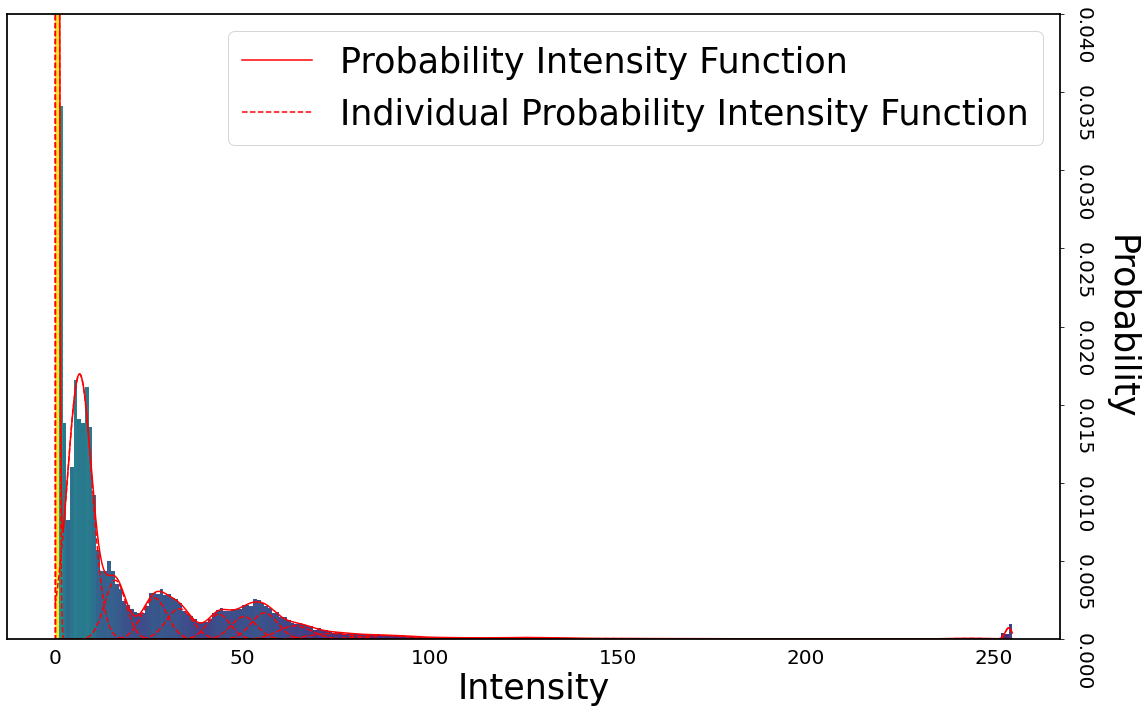

In [18]:
import matplotlib.pyplot as plt 
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 
import scipy.stats as stats

n_bins = 256

# Creating the figure
fig, axs = plt.subplots(1, 1, figsize =(16, 10), tight_layout = True) 
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.rcParams['axes.linewidth'] = 1.75

# Remove x, y ticks 
axs.xaxis.set_ticks_position('none') 
axs.yaxis.set_ticks_position('none') 

# Add padding between axes and labels 
axs.xaxis.set_tick_params(pad = 5) 
axs.yaxis.set_tick_params(pad = 10) 

# Creating histogram 
N, bins, patches = axs.hist(mean_img.reshape(-1,1), bins = n_bins,density=True) 

# Setting color 
fracs = ((N**(1 / 5)) / N.max()) 
norm = colors.Normalize(fracs.min(), fracs.max()) 

for thisfrac, thispatch in zip(fracs, patches): 
    color = plt.cm.viridis(norm(thisfrac)) 
    thispatch.set_facecolor(color) 
    
x = np.linspace(0,255,len(mean_img.reshape(-1,1)))
logprob = gmm.score_samples(x.reshape(-1,1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


l1 = plt.plot(x, pdf, '-r',label = 'Probability Intensity Function')
l2 = plt.plot(x, pdf_individual[:,0], '--r',label = 'Individual Probability Intensity Function')
l2 = plt.plot(x, pdf_individual[:,1:], '--r')

# Adding extra features

#plt.xlim(0, 100)
plt.ylim(0, 0.04)
plt.xlabel("Intensity",fontsize=35) 
plt.ylabel("Probability",fontsize=35,rotation=270,labelpad=45) 
plt.legend(fontsize=35)

# Show plot 

axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
plt.yticks(rotation=270)
plt.show() 

## 2.2 Center determination results

In [24]:
def find_center(data):
    #bw = opening(gmm_unmix[:,:,ind]*255, square(5))
    ret, thresh = cv.threshold(np.uint8(data), 127, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(
        thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    max_area = 0
    max_ind = 0
    areas = []
    for i in range(len(contours)):
        area = cv.contourArea(contours[i])
        areas.append(area)
    area_ind = np.argsort(areas)[::-1]
    if areas[area_ind[1]] < 200:
        (x, y), radius = cv.minEnclosingCircle(contours[area_ind[0]])
    else:
        (x, y), radius = cv.minEnclosingCircle(np.concatenate(
            (contours[area_ind[0]], contours[area_ind[1]]), axis=0))
    return x, y, radius

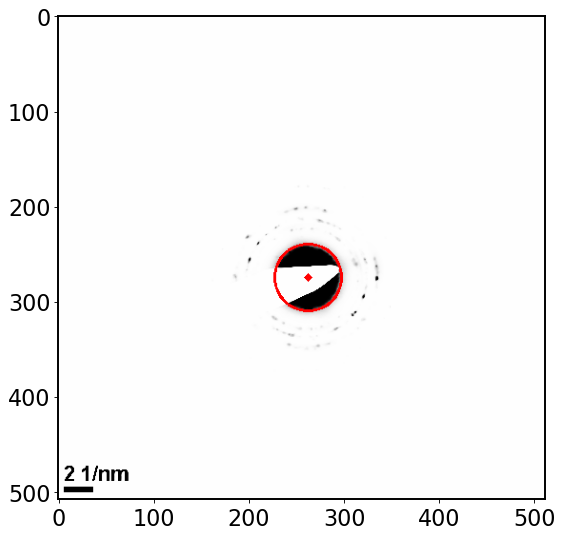

In [25]:
x_c, y_c, r = find_center(
    (prediction[:, :, mean_ind[2]] + prediction[:, :, mean_ind[1]]+prediction[:, :, mean_ind[0]])*255)
x_c_int = int(x_c + 0.5)
y_c_int = int(y_c + 0.5)
r_int = int(r + 0.5)
imm = cv.cvtColor(np.uint8((1-prediction[:, :, mean_ind[2]] - prediction[:, :, mean_ind[1]]-prediction[:, :, mean_ind[0]])*255),cv.COLOR_GRAY2BGR)
imm_center = imm.copy()
cv.circle(imm_center, (x_c_int, y_c_int), r_int, (255, 0, 0), 2)
cv.circle(imm_center, (x_c_int, y_c_int), 2, (255, 0, 0), 3)
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(imm_center)

## 2.3 Integral profile

In [16]:
def integral_func_beta(frame, center):
    
    center_x, center_y = center
    H,W = frame.shape
    
    number = min(H - center_y, center_y)
    number = int(min(min(center_x, number), W - center_x)+0.5)
    
    intensity = np.zeros(number)
    
    
    t = np.linspace(0,2*np.pi,1000)
    for ring in range(1,number):
        x_coors = center_x + ring * np.cos(t)
        y_coors = center_y + ring * np.sin(t)
        x_coors = np.array(x_coors + 0.5).astype(int).reshape(1,-1)
        y_coors = np.array(y_coors + 0.5).astype(int).reshape(1,-1)
        x_coors_index = np.where((x_coors < W) & (x_coors > 0))
        x_coors = x_coors[x_coors_index]
        y_coors = y_coors[x_coors_index]
        y_coors_index = np.where((y_coors < H) & (y_coors > 0))
        x_coors = x_coors[y_coors_index]
        y_coors = y_coors[y_coors_index]
        mask = np.zeros_like(frame)
        count = 0
        for i in range(len(y_coors)):
            h = y_coors[i]
            w = x_coors[i]
            if mask[h,w] == 0:
                intensity[ring] += frame[h,w]
                mask[h,w] = 1
                count += 1
        intensity[ring] = intensity[ring]/count
        #intensity[ring] = np.sum(frame[np.array(y_coors),np.array(x_coors)])/(frame[np.array(y_coors),np.array(x_coors)]).size
    return intensity

Text(0.5, 0, '1/d $\\mathrm{(nm^{-1}}$)')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


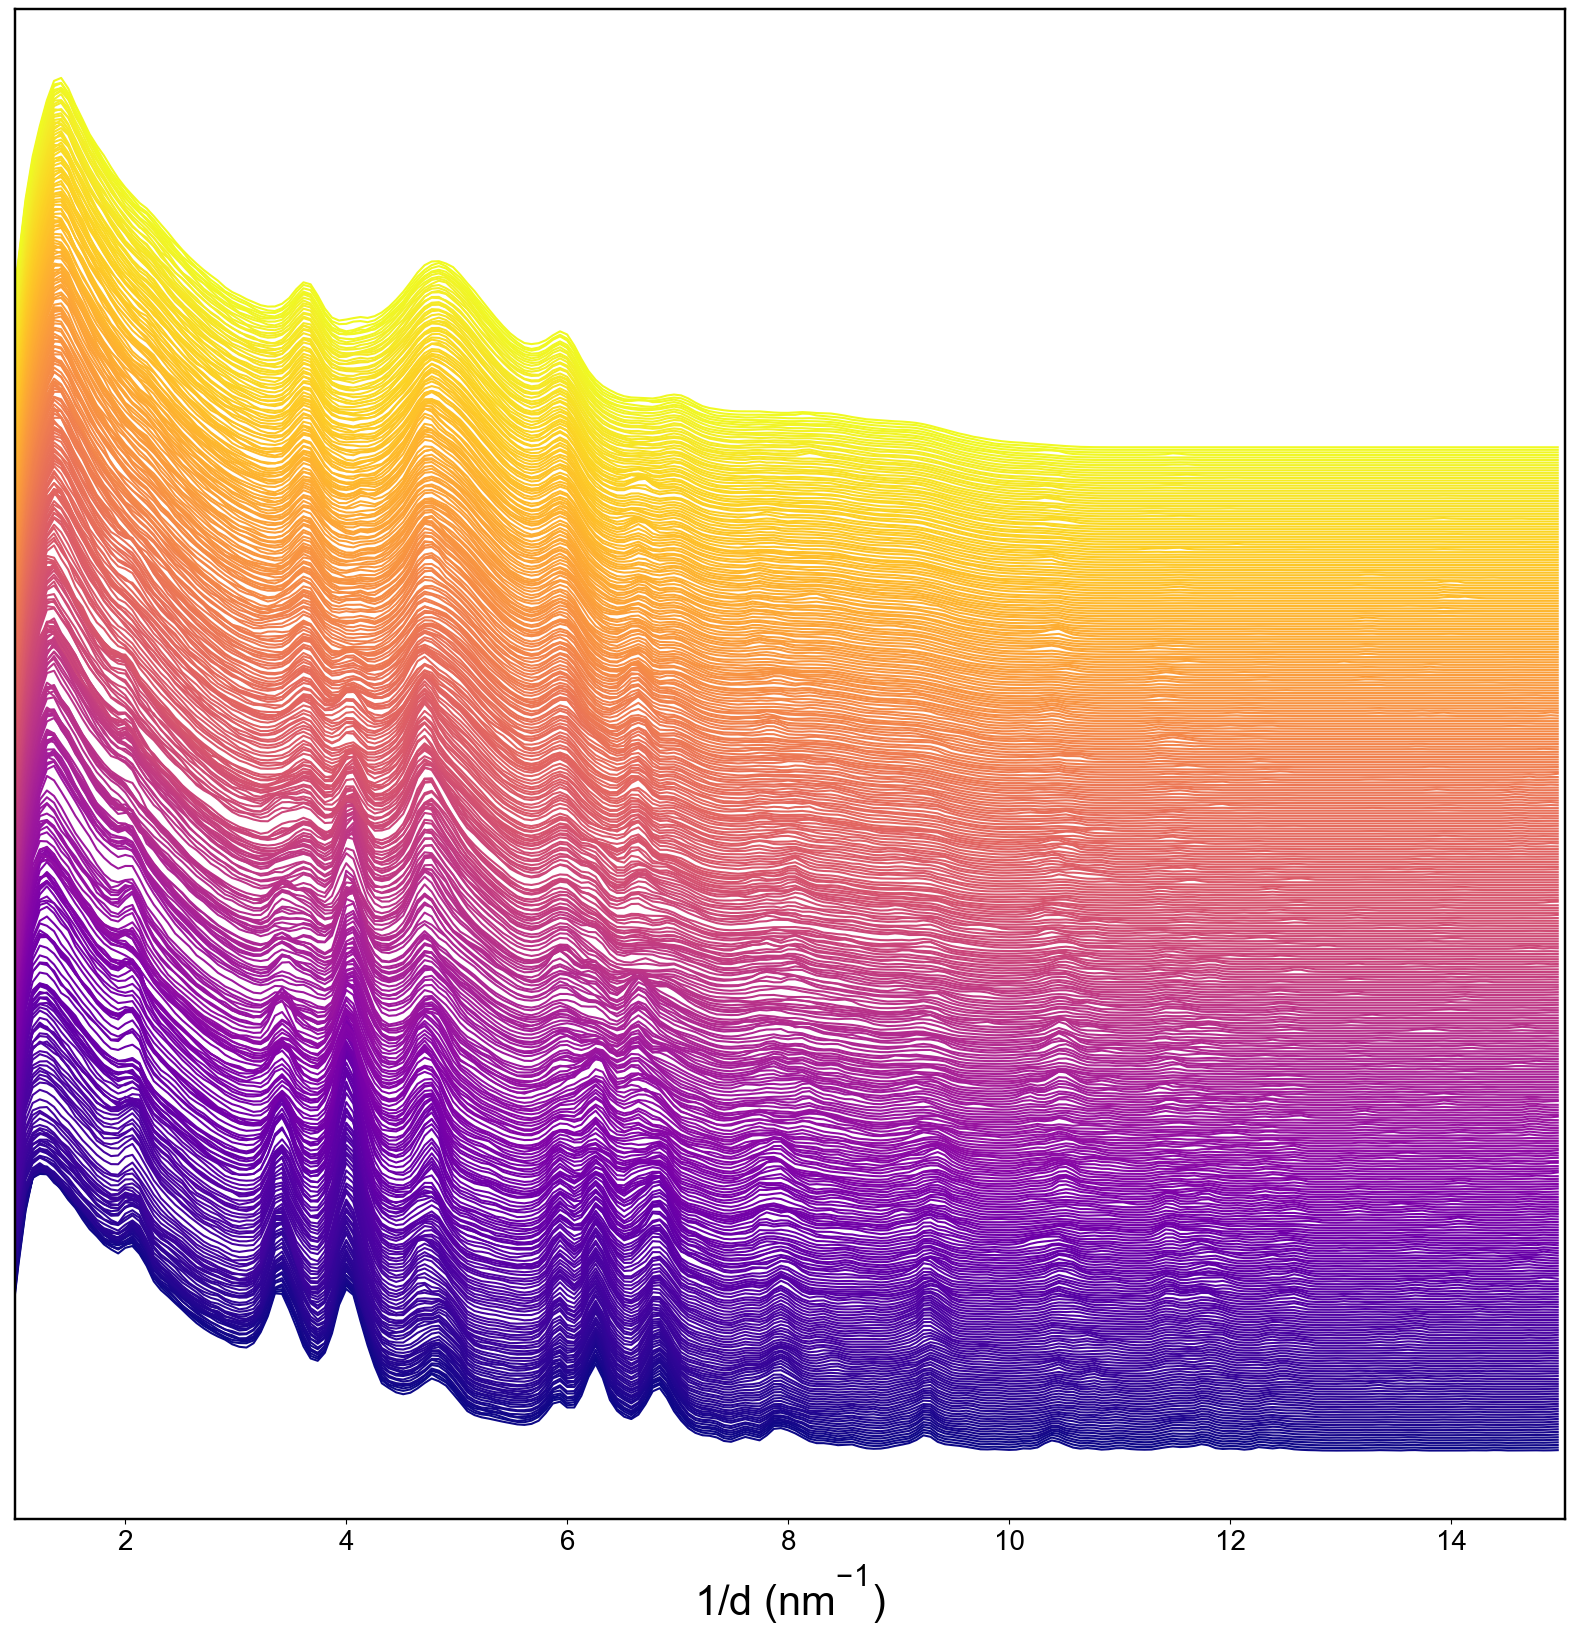

In [17]:
from sklearn import mixture
from scipy import optimize
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.rm'] = 'Arial'
plasma = cm.get_cmap('plasma', len(images))


fig = plt.figure(num=None, figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')
axs = fig.add_subplot(111)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.yticks([])
#plt.rc('ytick', labelsize=25)
for i in range(len(images)):
    intensity0 = integral_func(images[i], (center_x,center_y))+1000*i
    x = np.multiply(np.array(np.arange(0,len(intensity0))).ravel(),0.0645)
    plt.plot(x,intensity0.ravel(), color=plasma(i))
axs.set_xlim([1,len(intensity0)*0.0645])
axs.set_xlabel(r"1/d $\mathrm{(nm^{-1}}$)",fontsize=30,labelpad=5,fontname="Arial")


# 3. Elliptical Distortion Analysis

## 3.1 Local maxima localization

In [26]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

frame = images[-1]    
#center_x, center_y = center
H,W = frame.shape

number = min(H - center_y, center_y)
number = int(min(min(center_x, number), W - center_x)+0.5)

step = 0.3
intensity = np.zeros((2000,int((number-1)/step)))


t = np.linspace(0,2*np.pi,2000)

for i in range(1,int((number-1)/step)-1):
    ring = i * step
    x_coors = center_x + ring * np.cos(t)
    y_coors = center_y + ring * np.sin(t)
    for j in range(len(x_coors)):
        if (x_coors[j] < W) and (x_coors[j] > 0) and (y_coors[j] < H) and (y_coors[j] > 0):
            x_l = int(x_coors[j])
            y_l = int(y_coors[j])
            x_r = int(x_coors[j]+0.5)
            y_r = int(y_coors[j] + 0.5)
            w1 = 1 - np.sqrt((x_coors[j]-x_l)**2 + (y_coors[j]-y_l)**2)
            w2 = 1 - np.sqrt((x_coors[j]-x_r)**2 + (y_coors[j]-y_l)**2)
            w3 = 1 - np.sqrt((x_coors[j]-x_l)**2 + (y_coors[j]-y_r)**2)
            w4 = 1 - np.sqrt((x_coors[j]-x_r)**2 + (y_coors[j]-y_r)**2)
        
            w1_ = w1/(w1+w2+w3+w4)
            w2_ = w2/(w1+w2+w3+w4)
            w3_ = w3/(w1+w2+w3+w4)
            w4_ = w4/(w1+w2+w3+w4)
            intensity[j,i] = w1_*frame[y_l,x_l] + w2_*frame[y_l,x_r] + w3_*frame[y_r,x_l] + w4_*frame[y_r,x_r]
    #x_coors = np.array(x_coors + 0.5).astype(int).reshape(1,-1)
    #y_coors = np.array(y_coors + 0.5).astype(int).reshape(1,-1)
    #x_coors_index = np.where((x_coors < W) & (x_coors > 0))
    #x_coors = x_coors[x_coors_index]
    #y_coors = y_coors[x_coors_index]
    #y_coors_index = np.where((y_coors < H) & (y_coors > 0))
    #x_coors = x_coors[y_coors_index]
    #y_coors = y_coors[y_coors_index]

    #intensity[:,i] = frame[np.array(y_coors),np.array(x_coors)]

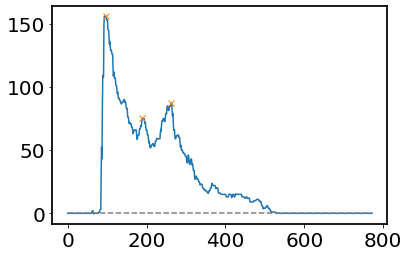

In [27]:
x = intensity[0,:]
peaks, _ = find_peaks(x, height=60,width=5,distance = 30)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [28]:
peaks

array([ 97, 189, 263], dtype=int64)

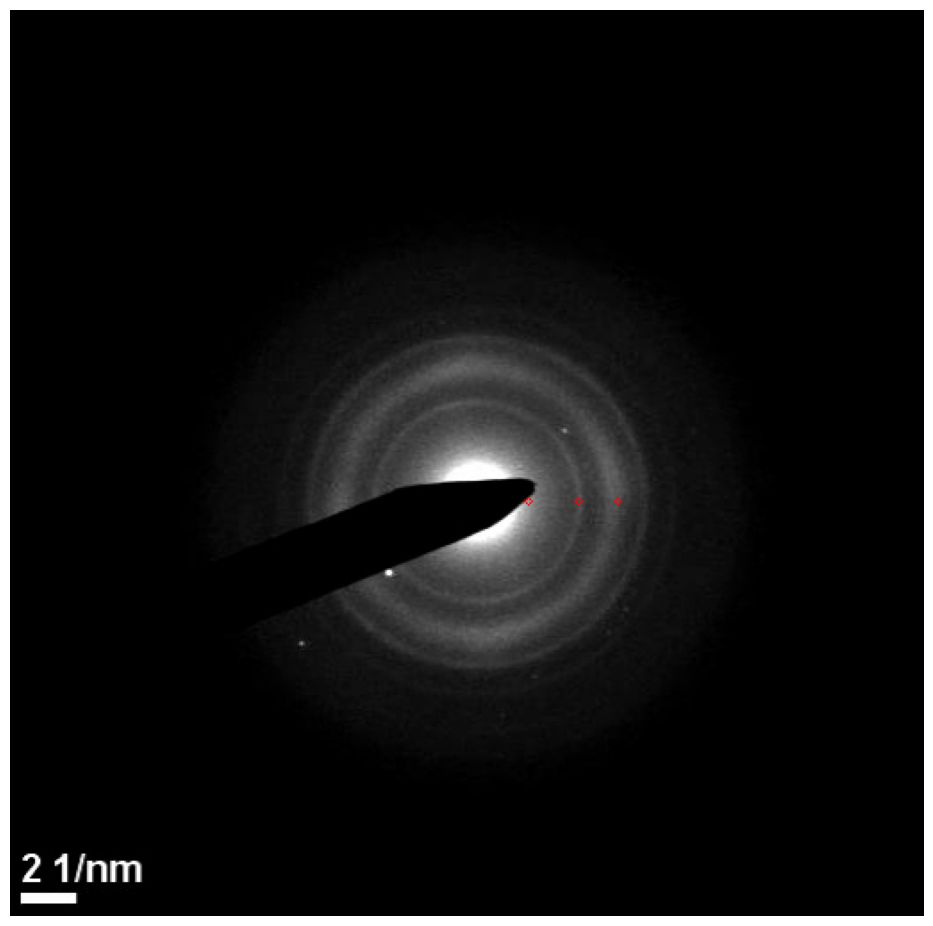

In [29]:
plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
plt.axis('off')
test_image = images[-1].copy()
display_image = cv.cvtColor(test_image,cv.COLOR_GRAY2BGR)
for i in range(len(peaks)):
    cv.circle(display_image,(int(center_x+peaks[i]*step+0.5),int(center_y+0.5)),2,(255,0,0),1)
plt.imshow(display_image)

In [30]:
all_peaks = []
display_image = cv.cvtColor(255-images[-1],cv.COLOR_GRAY2BGR)
points = []
phi = []
for i in range(0,2000,7):
    x = intensity[i,:]
    peaks, _ = find_peaks(x,height=50,width=3,distance = 10)
    all_peaks.append(peaks)
    for j in range(len(peaks)):
        #if peaks[j]*step > 55and peaks[j]*step < 80:
         #   cv.circle(display_image,(int(center_x+peaks[j]*step*np.cos(t[i])),int(center_y+peaks[j]*step*np.sin(t[i]))),3,(255,0,0),1)
        if peaks[j]*step < 57.5 and peaks[j]*step > 56:
            cv.circle(display_image,(int(center_x+peaks[j]*step*np.cos(t[i])),int(center_y+peaks[j]*step*np.sin(t[i]))),3,(255,0,0),1)
            points.append((center_x+peaks[j]*step*np.cos(t[i]),center_y+peaks[j]*step*np.sin(t[i])))
            phi.append(t[i])

<ipython-input-30-ddc3d20e5690>:7: PeakPropertyWarning: some peaks have a width of 0
  peaks, _ = find_peaks(x,height=50,width=3,distance = 10)


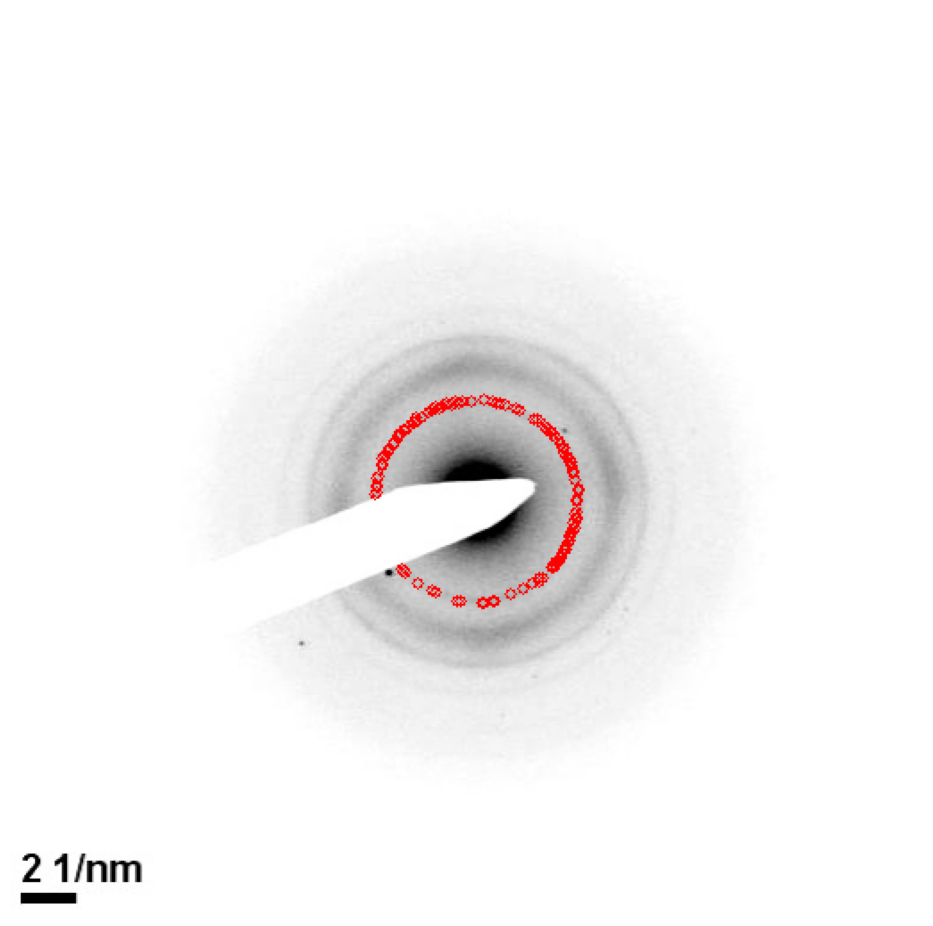

In [31]:
plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
plt.axis('off')
plt.imshow(display_image)

## 3.2 Ellipse fitting

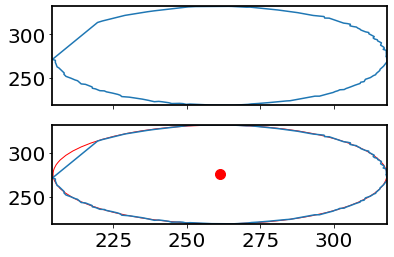

In [32]:
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
a_points = np.array(points)
x = a_points[:, 0]
y = a_points[:, 1]

ell = EllipseModel()
ell.estimate(a_points)

xc, yc, a, b, theta = ell.params

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].plot(x,y)

axs[1].plot(x, y)
axs[1].scatter(xc, yc, color='red', s=100)
axs[1].set_xlim(x.min(), x.max())
axs[1].set_ylim(y.min(), y.max())

ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

axs[1].add_patch(ell_patch)
plt.show()

In [33]:
# the center of the fitted ellipse
xc,yc

(261.30035827420807, 275.4451628738097)

In [34]:
# the semi-axis
a,b

(56.420953262360925, 56.785123170693694)

In [35]:
# rotation 
np.degrees(theta)

75.78962868843945

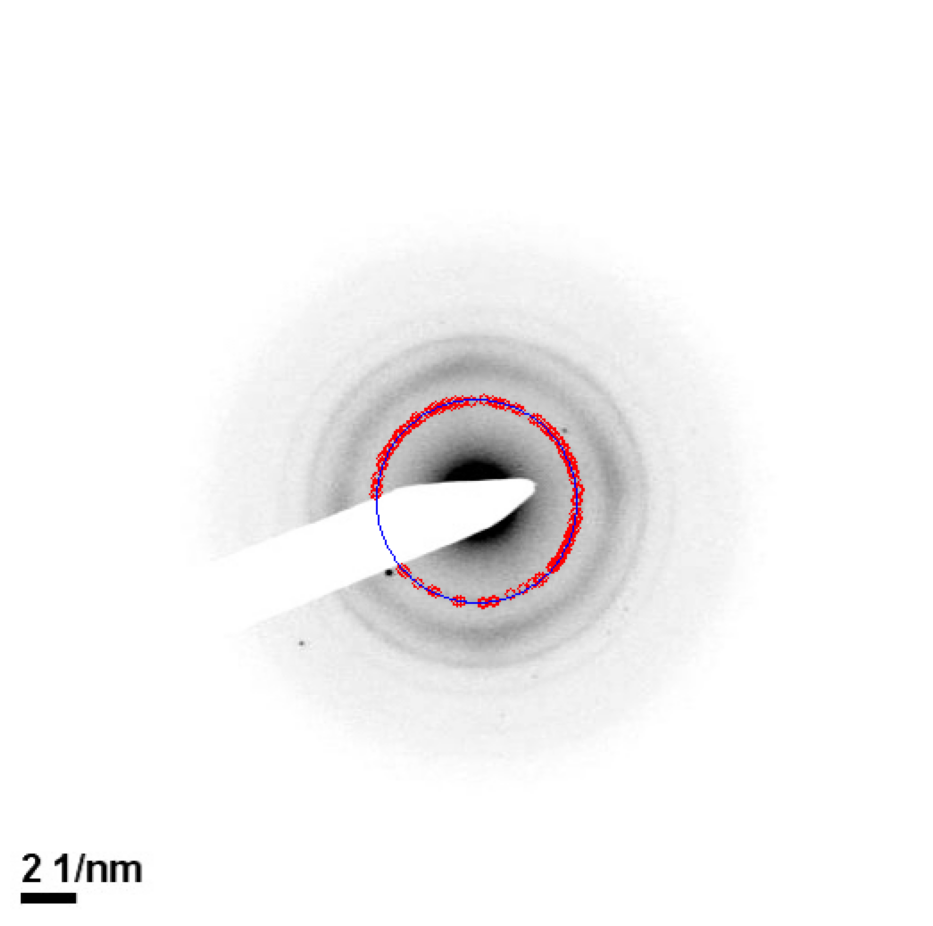

In [36]:
plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
plt.axis('off')
cv.ellipse(display_image, (int(xc+0.5),int(yc+0.5)), (int(b+0.5),int(a+0.5)), 
           theta*180/np.pi, 0, 360, (0,0,255), 1) 
plt.imshow(display_image)

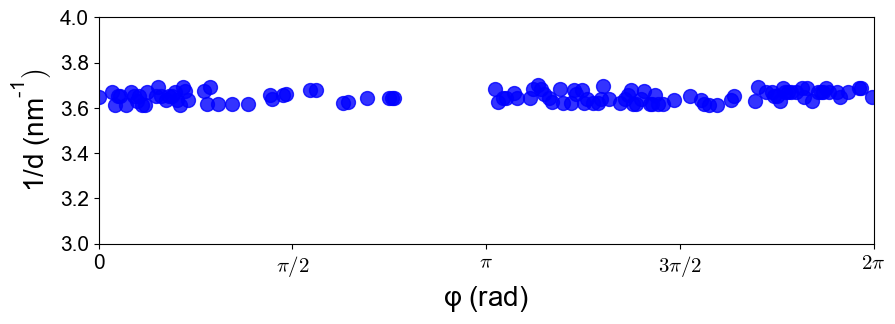

In [37]:
adjusted_xc = xc
adjusted_yc = yc
fitting_radius = np.sqrt((a_points[:,0] - adjusted_xc)**2 + (a_points[:,1] - adjusted_yc)**2)
fitting_radius = fitting_radius * 0.0645
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.8
radius_change = []
ellipse_radius = []
x_tick = [0,0.5,1,1.5,2]
x_label = ["0",r"${\pi}/2$", r"${\pi}$", r"$3{\pi}/2$", r"$2{\pi}$"]

radius_change = np.array(radius_change)
phi = np.array(phi)
f = plt.figure(num=None, figsize=(10, 3), dpi=100, facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
axs = f.add_subplot(111)
#plt.plot(phi,radius_change,'ro', label = 'fitting radius',markersize = 10, alpha = 0.5)
plt.plot(phi,fitting_radius,'bo', label = 'orginal radius', markersize = 10, alpha = 0.8)
#axs.hlines(y=np.mean(radius_change),xmin=np.min(phi),xmax=np.max(phi), color="black", linestyle="--", label='mean value of original radius')
axs.set_ylim([3.0,4.0])
axs.set_xlim([np.min(phi),np.max(phi)])
#legend = axs.legend(loc='upper right', shadow=True, fontsize='x-large')
axs.set_xticks(np.array(x_tick)*np.pi)
axs.set_xticklabels(x_label, fontsize=15)
axs.set_ylabel("1/d ($\mathregular{nm^{-1}})$", fontsize=20,fontname="Arial")
axs.set_xlabel("$\mathregular{\\varphi}$ (rad)", fontsize=20,fontname="Arial")
plt.show()

# 4. Center Drift Analysis

In [30]:
from skimage.measure import CircleModel
centers = []

for m in range(300,len(images)):
    temp_image = images[m].copy()
    temp_image[470:504,2:79] = 0
    #w_tophat = white_tophat(temp_image, selem)
    intensity = np.zeros((2000,int((number-1)/step)))
    for i in range(1,int((number-1)/step)-1):
        ring = i * step
        x_coors = center_x + ring * np.cos(t)
        y_coors = center_y + ring * np.sin(t)
        for j in range(len(x_coors)):
            if (x_coors[j] < W) and (x_coors[j] > 0) and (y_coors[j] < H) and (y_coors[j] > 0):
                x_l = int(x_coors[j])
                y_l = int(y_coors[j])
                x_r = int(x_coors[j]+0.5)
                y_r = int(y_coors[j] + 0.5)
                w1 = 1 - np.sqrt((x_coors[j]-x_l)**2 + (y_coors[j]-y_l)**2)
                w2 = 1 - np.sqrt((x_coors[j]-x_r)**2 + (y_coors[j]-y_l)**2)
                w3 = 1 - np.sqrt((x_coors[j]-x_l)**2 + (y_coors[j]-y_r)**2)
                w4 = 1 - np.sqrt((x_coors[j]-x_r)**2 + (y_coors[j]-y_r)**2)

                w1_ = w1/(w1+w2+w3+w4)
                w2_ = w2/(w1+w2+w3+w4)
                w3_ = w3/(w1+w2+w3+w4)
                w4_ = w4/(w1+w2+w3+w4)
                intensity[j,i] = w1_*temp_image[y_l,x_l] + w2_*temp_image[y_l,x_r] + w3_*temp_image[y_r,x_l] + w4_*temp_image[y_r,x_r]
    points = []
    for i in range(0,2000,7):
        x = intensity[i,:]
        peaks, _ = find_peaks(x,height=50,width=3,distance = 10)
        all_peaks.append(peaks)
        for j in range(len(peaks)):
            if peaks[j]*step < 57.5 and peaks[j]*step > 56:
                points.append((center_x+peaks[j]*step*np.cos(t[i]),center_y+peaks[j]*step*np.sin(t[i])))
    a_points = np.array(points)
    x = a_points[:, 0]
    y = a_points[:, 1]

    ell = CircleModel()
    ell.estimate(a_points)

    xc, yc, rc = ell.params
    
    centers.append((xc,yc))

<ipython-input-30-408c8f58735f>:32: PeakPropertyWarning: some peaks have a width of 0
  peaks, _ = find_peaks(x,height=50,width=3,distance = 10)


In [31]:
centers = np.array(centers)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


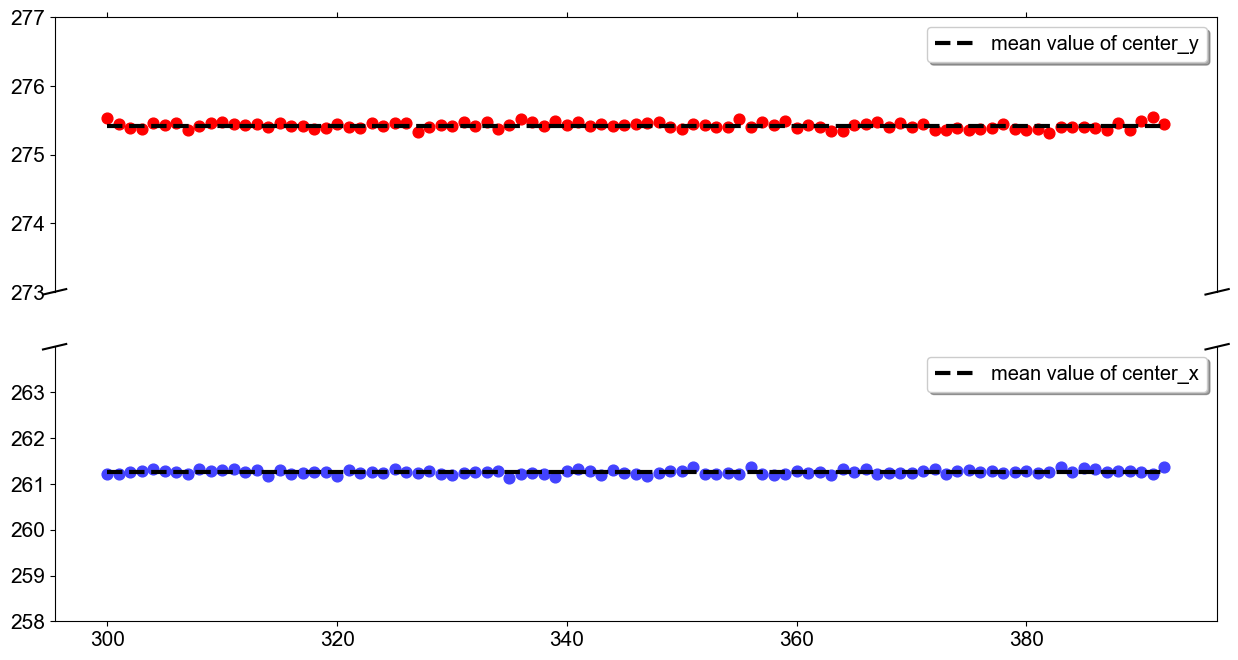

In [32]:
import matplotlib.pyplot as plt
#f = plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams['font.family'] = 'Arial'

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
f, (axs, ax2) = plt.subplots(2, 1, figsize = (15, 8), dpi = 100, sharex=True)
#axs, ax2 = f.add_subplot(111)

x = np.arange(300, len(images))
start_index = 0
median_x = np.median(centers[start_index:,0])
median_y = np.median(centers[start_index:,1])
max_dis_x = np.max(abs(centers[start_index:,0]-median_x))
#min_dis_x = np.min(abs(centers[filtered_centers_coors,0]-median_x))
max_dis_y = np.max(abs(centers[start_index:,1]-median_y))
#min_dis_y = np.max(abs(centers[filtered_centers_coors,1]-median_y))
colors_x = 1-abs(centers[start_index:,0]-median_x)/max_dis_x
colors_y = 1-abs(centers[start_index:,1]-median_y)/max_dis_y

ax2.scatter(x[start_index:], centers[start_index:,0], c = (67/255,67/255,255/255), s=60)
axs.scatter(x[start_index:], centers[start_index:,1], c = "red",s=60)
#ax2.hlines(y=center_x,xmin=start_index,xmax=len(images)-1, color="blue", linestyle="--", linewidths = 2.0, label='center_x from video')
ax2.hlines(y=median_x,xmin=300,xmax=len(images)-1, color="black", linestyle="--", linewidths = 3.0,label='mean value of center_x')
#axs.hlines(y=center_y,xmin=start_index,xmax=len(images)-1, color="red", linestyle="--",linewidths = 2.0, label='center_y from video')
axs.hlines(y=median_y,xmin=300,xmax=len(images)-1, color="black", linestyle="--", linewidths = 3.0,label='mean value of center_y')

axs.set_ylim(273, 277)  # outliers only
ax2.set_ylim(258, 264)  # most of the data

axs.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
axs.xaxis.tick_top()
axs.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs.transAxes, color='k', clip_on=False)
axs.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axs.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

axs.legend(loc='upper right', shadow=True, fontsize='x-large')
#axs.set_ylabel("r", fontsize=30,fontname="Arial")
#axs.set_xlabel("$\mathregular{\\varphi}$/rad", fontsize=30,fontname="Arial")
ax2.legend(loc='upper right', shadow=True, fontsize='x-large')
start, end = ax2.get_ylim()
ax2.yaxis.set_ticks(np.arange(start, end, 1))
#axs.set_ylim([250,270])

In [33]:
np.var(centers[start_index:,0]),np.var(centers[start_index:,1])

(0.002296363099865028, 0.002086784627170493)

Text(0.5, 0, 'Frame number')

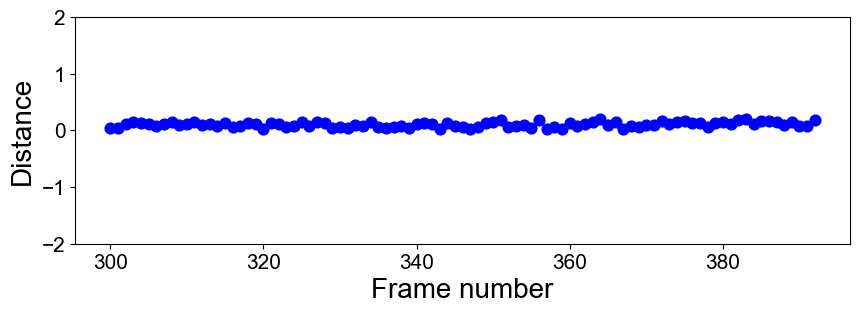

In [34]:
import matplotlib.pyplot as plt
#f = plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams['font.family'] = 'Arial'

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
f, axs = plt.subplots(1, 1, figsize = (10, 3), dpi = 100)
#axs, ax2 = f.add_subplot(111)

x = np.arange(300, len(images))
start_index = 0

distance_center = np.sqrt((centers[:,0] - center_x)**2 + (centers[:,1] - center_y)**2)


max_dis = np.max(abs(distance_center))

colors = 1-abs(distance_center[start_index:])/max_dis

axs.scatter(x[start_index:], distance_center[start_index:], c = "blue",s=60)

#axs.hlines(y=0,xmin=start_index,xmax=len(images)-1, color="blue", linestyle="--", linewidths = 2.0)

axs.set_ylim(-2, 2)  # outliers only
axs.set_ylabel("Distance", fontsize=20,fontname="Arial")
axs.set_xlabel("Frame number", fontsize=20,fontname="Arial")
#axs.legend(loc='upper right', shadow=True, fontsize='x-large')
#axs.set_ylabel("r", fontsize=30,fontname="Arial")
#axs.set_xlabel("$\mathregular{\\varphi}$/rad", fontsize=30,fontname="Arial")

In [35]:
np.var(distance_center)

0.001943346799176615

In [36]:
np.mean(distance_center)

0.10517297612848675

# 5. Simulation of three cases of distortion

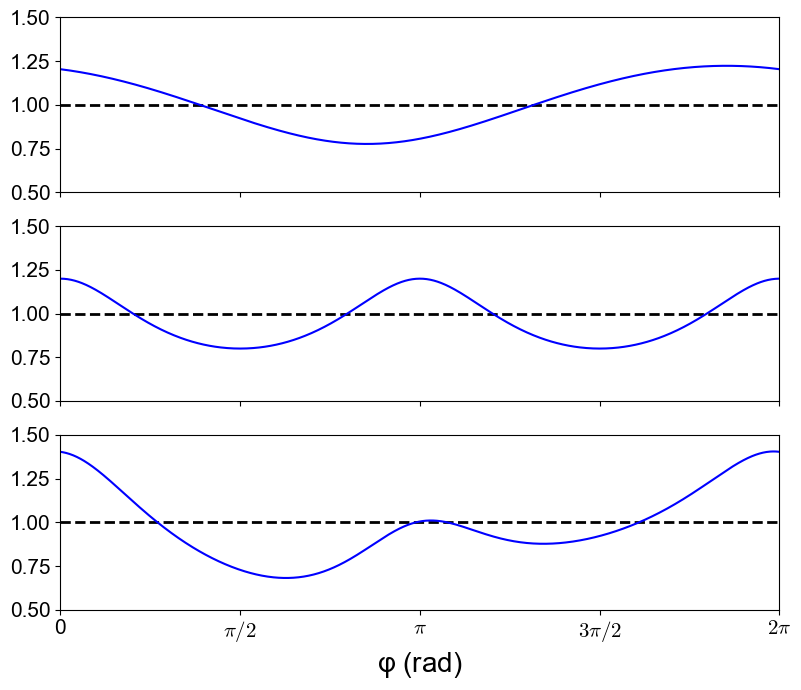

In [37]:
# original center is (0,0)
# radius is 1
from matplotlib.patches import Circle,Ellipse
from matplotlib.collections import PatchCollection

# angles
t = np.linspace(0,2*np.pi,1000)
x_tick = [0,0.5,1,1.5,2]
x_label = ["0",r"${\pi}/2$", r"${\pi}$", r"$3{\pi}/2$", r"$2{\pi}$"]

## case 1, center is incorrect for a circle
delta_x = -0.2
delta_y = 0.1

patches1 = []
case1 = plt.Circle((delta_x, delta_y), 1, color='b',clip_on=False)
radius1 = np.sqrt((np.cos(t)-delta_x)**2 + (np.sin(t) - delta_y)**2)

## case 2, ellipse distortion
aa = 1.2
bb = 0.8
ellipse_r = aa*bb/np.sqrt((aa*np.sin(t))**2 + (bb*np.cos(t))**2)
radius2 = ellipse_r
case2 = Ellipse((0, 0),  2*aa, 2*bb, edgecolor='b',clip_on=False)

## case 3, center is incorrect for an ellipse

radius3 = np.sqrt((np.multiply(ellipse_r,np.cos(t)) - delta_x)**2 + (np.multiply(ellipse_r,np.sin(t)) - delta_y)**2)
case3 = Ellipse((delta_x, delta_y),  2*aa, 2*bb, edgecolor='b',clip_on=False)
 

plt.rcParams['font.family'] = 'Arial'

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
f, (axs, ax2,  ax3) = plt.subplots(3, 1, figsize = (8, 7), dpi = 100, sharex=True)
axs.plot(t,radius1,c='b')
#axs.add_artist(case1)
ax2.plot(t,radius2,c = 'b')
#ax2.add_artist(case2)
ax3.plot(t,radius3,c = 'b')
#ax3.add_artist(case3)

axs.hlines(y=1.0,xmin=np.min(t),xmax=np.max(t), color="k", linestyle="--", linewidths = 2.0)
ax2.hlines(y=1.0,xmin=np.min(t),xmax=np.max(t), color="k", linestyle="--", linewidths = 2.0)
ax3.hlines(y=1.0,xmin=np.min(t),xmax=np.max(t), color="k", linestyle="--", linewidths = 2.0)
axs.set_ylim([0.5,1.5])
ax2.set_ylim([0.5,1.5])
ax3.set_ylim([0.5,1.5])
axs.set_xlim([np.min(t),np.max(t)])
ax3.set_xticks(np.array(x_tick)*np.pi)
ax2.set_xticklabels(x_label, fontsize=15)
#legend = axs.legend(loc='upper right', shadow=True, fontsize='x-large')
#axs.set_ylabel("1/d ($\mathregular{nm^{-1}})$", fontsize=30,fontname="Arial")
ax3.set_xlabel("$\mathregular{\\varphi}$ (rad)", fontsize=20,fontname="Arial")
f.tight_layout()
plt.show()

# 6. Elliptical distortion correction

In [38]:
index = 2294
new_rs_for_index = np.zeros(len(bboxes[index]))
ori_rs_for_index = np.zeros(len(bboxes[index]))

for i in range(len(bboxes[index])):
    y,x,y_len,x_len = tuple(map(float, bboxes[index][i].split(', ')))
    y_ori = y + y_len/2
    x_ori = x + x_len/2
    
    #new_x, new_y = ellipse_distortion_correct((x_ori,y_ori),(center_x,center_y),(a,b),-theta)
    ori_rs_for_index[i] = np.sqrt((y_ori-center_y)**2+(x_ori-center_x)**2)
    t0 = np.arctan2(y_ori-center_y, x_ori-center_x) - theta
    xn = a*np.cos(theta)*np.cos(t0) - b*np.sin(theta)*np.sin(t0)
    yn = a*np.sin(theta)*np.cos(t0) + b*np.cos(theta)*np.sin(t0)
    scale = min(a,b)/np.sqrt(xn**2+yn**2)
    
    #cos_theta = new_x/np.sqrt(new_y**2 + new_x**2)
    #sin_theta = new_y/np.sqrt(new_y**2 + new_x**2)
    #cos_t = new_x/a
    #sin_t = new_y/b
    #new_rs_for_index[i] = np.sqrt(new_y**2 + new_x**2)*min(a,b)/np.sqrt((a*cos_theta)**2+(b*sin_theta)**2)
    new_rs_for_index[i] = ori_rs_for_index[i]*scale

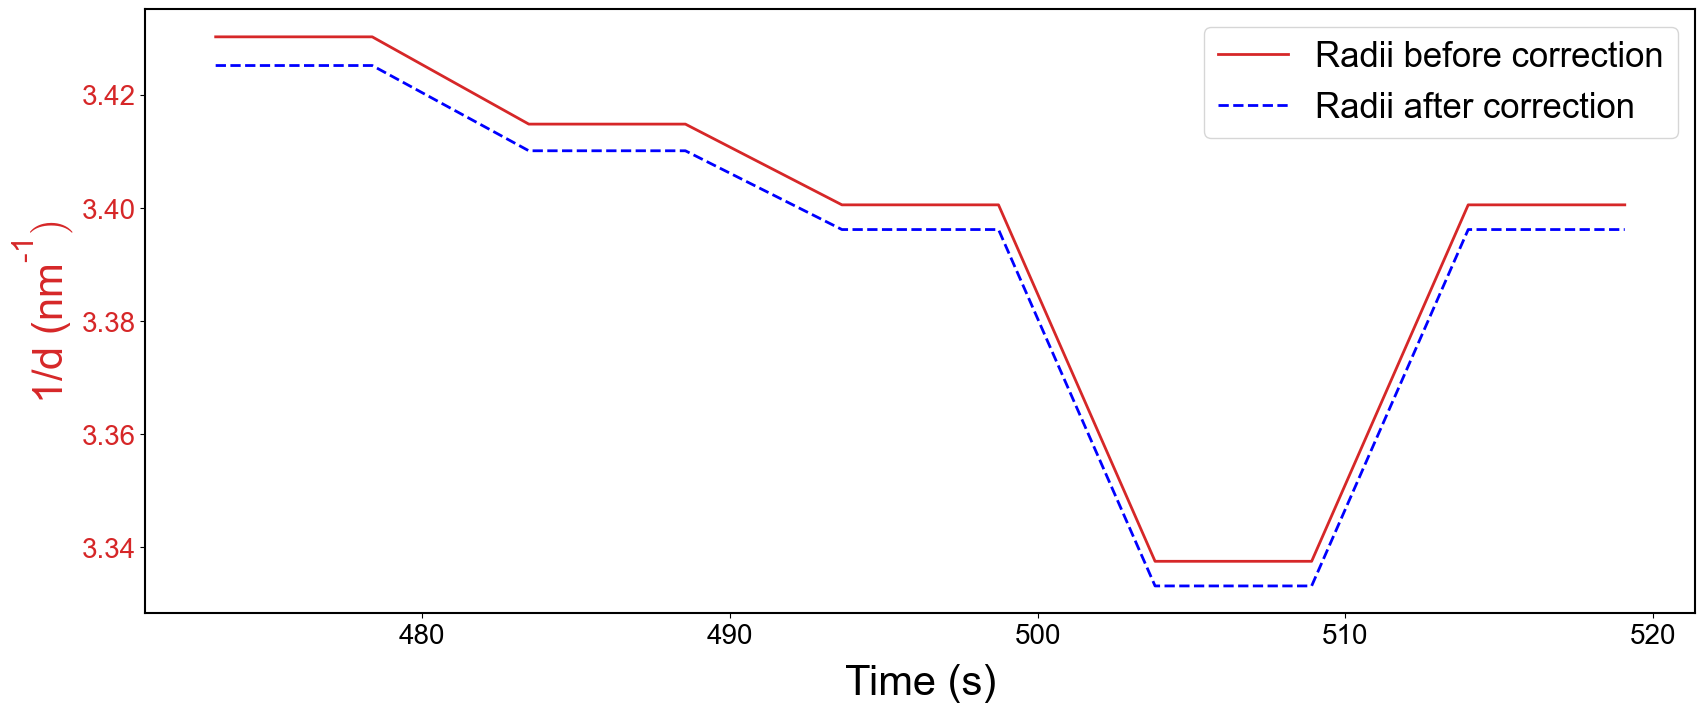

In [39]:
plt.rcParams['font.family'] = 'Arial'

frame_start = frames[index][0]
frame_end = frames[index][1]
f = plt.figure(num=None, figsize=(20, 8), dpi=100, facecolor='w', edgecolor='k')

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.rcParams['axes.linewidth'] = 1.5

color = 'tab:red'
axs = f.add_subplot(111)
axs.set_ylabel("1/d ($\mathregular{nm^{-1}})$", color=color,fontsize=30,fontname="Arial")
axs.plot(np.multiply(np.arange(frame_start,frame_end),2000/393),np.multiply(ori_rs_for_index,0.0645),
         color=color,linewidth=2,label = 'Radii before correction')
axs.plot(np.multiply(np.arange(frame_start,frame_end),2000/393),np.multiply(new_rs_for_index,0.0645),
         color='b',linestyle='dashed',linewidth=2, label = 'Radii after correction')
#axs.yaxis.tick_left()
axs.tick_params(axis='y', labelcolor=color)

axs.set_xlabel("Time (s)",fontsize=30,labelpad=10,fontname="Arial")
plt.legend(fontsize=25)


plt.show()

# 7. Calculate radii, angles and intensity

In [38]:
a,b

(56.420953262360925, 56.785123170693694)

In [39]:
rs = []
angles = []
densities = []
sizes = []
for i in range(len(frames)):
    angle = np.zeros(len(bboxes[i]))
    r = np.zeros(len(bboxes[i]))
    density = np.zeros(len(bboxes[i]))
    size = np.zeros(len(bboxes[i]))
    y0,x0,y_len0,x_len0 = tuple(map(float, bboxes[i][0].split(', ')))
    flag = np.arctan((y0 + y_len0/2 - center_y)/(x0 + x_len0/2 - center_x))>0
    for index in range(len(bboxes[i])):
        # read the frame
        frame_number = frames[i][0] + index

        gray = images[frame_number]

        y,x,y_len,x_len = tuple(map(float, bboxes[i][index].split(', ')))
        y_ori = y + y_len/2
        x_ori = x + x_len/2
        
        t0 = np.arctan2(y_ori-center_y, x_ori-center_x) - theta
        xn = a*np.cos(theta)*np.cos(t0) - b*np.sin(theta)*np.sin(t0)
        yn = a*np.sin(theta)*np.cos(t0) + b*np.cos(theta)*np.sin(t0)
        scale = min(a,b)/np.sqrt(xn**2+yn**2)
        
        r[index] = np.sqrt((y_ori-center_y)**2 + (x_ori-center_x)**2)*scale
        #r[index] = np.sqrt((y + y_len/2 - center_y)**2 + (x + x_len/2 - center_x)**2)
        dy = y_ori-center_y
        dx = x_ori-center_x
        angle[index] = np.degrees(np.arctan2(dy,dx)) % 360
        if index > 0:
            if (angle[index - 1] - angle[index]) > 270:
                angle[index] = angle[index] + 360
            if (angle[index] - angle[index - 1]) > 270:
                angle[index] = angle[index] - 360
    
        size[index] = y_len * x_len
        density[index] = np.sum(gray[int(y+0.5):int(y+y_len+0.5),int(x+0.5):int(x+x_len+0.5)])
    rs.append(r)
    angles.append(angle)
    densities.append(density)
    sizes.append(size)
    if i>0 and i%1000==0:
        print("{} processed".format(i))

1000 processed
2000 processed
3000 processed
4000 processed
5000 processed
6000 processed
7000 processed


In [40]:
rs_mean = np.zeros(len(rs))
rs_var = np.zeros(len(rs))
for i in range(len(rs)):
    rs_mean[i] = np.mean(rs[i])
    rs_var[i] = np.var(rs[i])

## 7.1 Global changes of radii and angles

<ipython-input-41-2047017be4ae>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['1.9', '6.0', '10.1', '14.3','18.4', '22.5'])


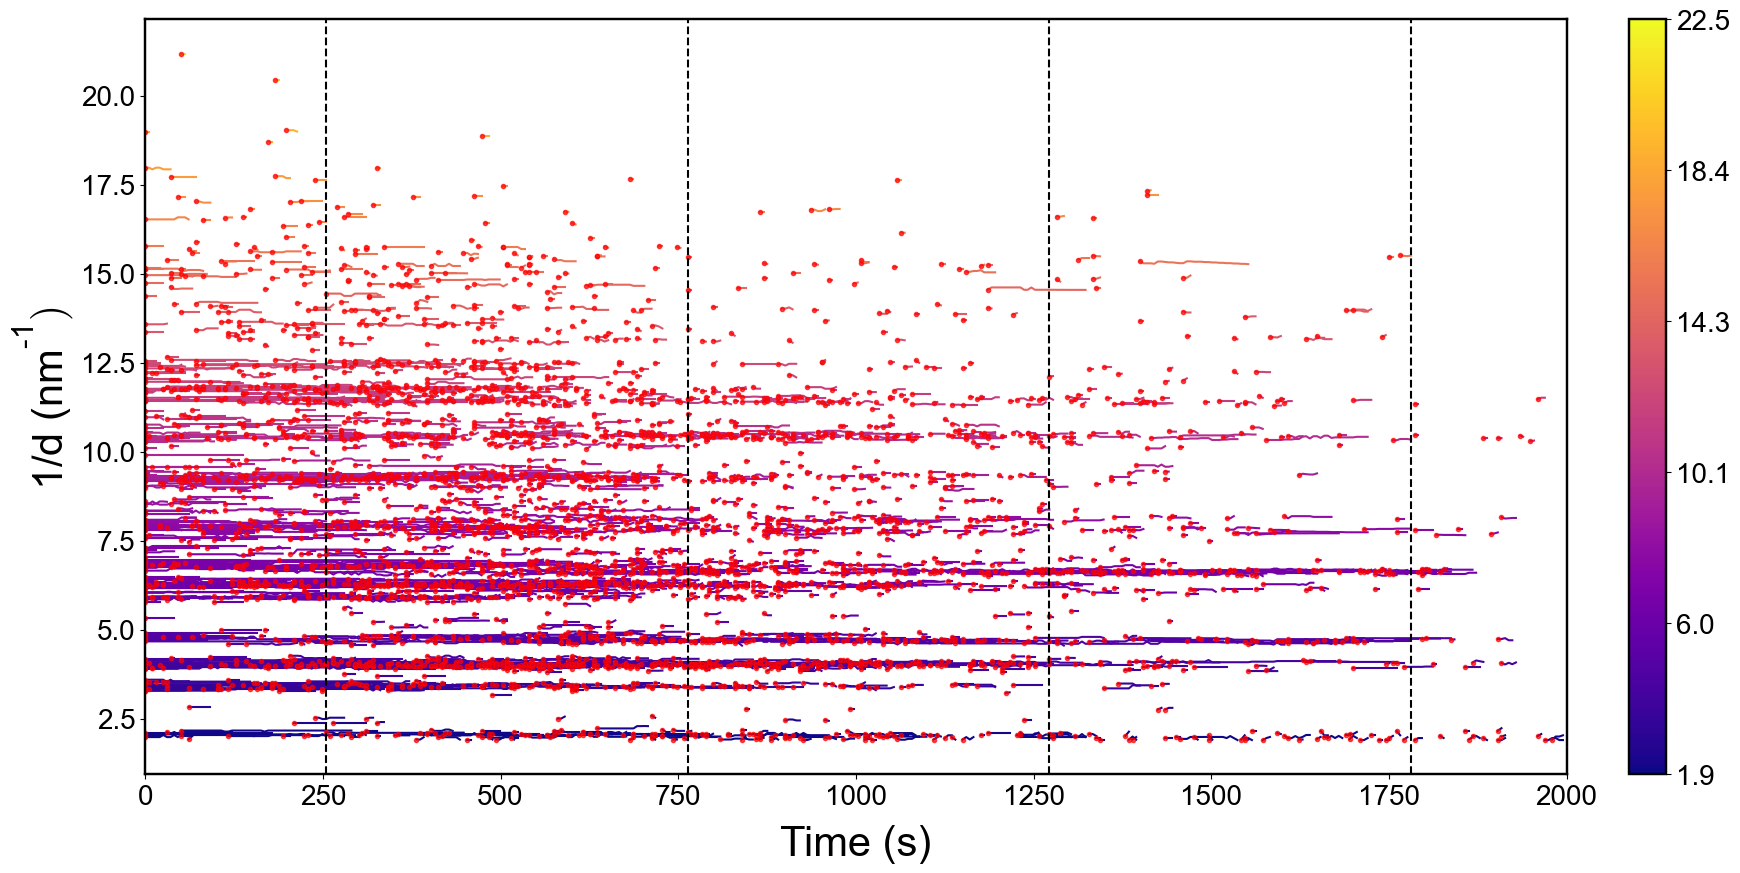

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mlt
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.75
fs = np.arange(0,len(images))
r_max = np.max(rs_mean)
r_min = np.min(rs_mean)
f = plt.figure(num=None, figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

plt.rc('ytick', labelsize=20)


ax = f.add_subplot(111)
#ax2 = ax.twiny()

rs_var_mean = np.mean(rs_var)
plasma = plt.cm.get_cmap('plasma',int(r_max-r_min+1))
#plt.yticks(rings,ring_string)
#for i in range(len(rings)):
    
    #plt.plot(fs, [rings[i]]*len(fs),'k--')

analyze_radius_spots = []
    
for i in range(len(rs_mean)):
    if (frames[i][1] - frames[i][0]) > 1 and (np.max(rs[i])-np.min(rs[i]))<=2:
        color = plasma((rs_mean[i]-r_min)/(r_max - r_min))[0:3]
        ax.plot(np.multiply(np.arange(frames[i][0],frames[i][1]),2000/393), np.multiply(rs[i],0.0645), color = color)
        ax.plot(frames[i][0]/393*2000,rs[i][0]*0.0645, 'r.',alpha=0.7)
        
        analyze_radius_spots.append(i)
#plt.axvline(x=98,color="black", linestyle="--")
ax.axvline(x=50/393*2000,color="black", linestyle="--")
ax.axvline(x=150/393*2000,color="black", linestyle="--")
ax.axvline(x=250/393*2000,color="black", linestyle="--")
ax.axvline(x=350/393*2000,color="black", linestyle="--")
#ax.set_ylim([1,13])
ax.set_xlim([0,2000])
ax.xaxis.set_ticks([0,250,500,750,1000,1250,1500,1750,2000])
#ax2.set_xlim([0,2000])
#plt.grid(True,alpha=0.3)
ax.set_xlabel("Time (s)",fontsize=30,labelpad=10,fontname="Arial") 
ax.set_ylabel("1/d ($\mathregular{nm^{-1}})$",fontsize=30,fontname="Arial") 
#ax2.set_xlabel("Time (s)",fontsize=30,labelpad=10) 
#ticks = (([2,4,6,8,10,12])/0.0645-r_min)/(r_max-r_min)
#norm = mlt.colors.Normalize(vmin=(1/0.0645-r_min)/(r_max-r_min),vmax =(13/0.0645-r_min)/(r_max-r_min))
cbar = plt.colorbar(cm.ScalarMappable(cmap = plasma),ax = ax, fraction=0.043, pad=0.04)
#plt.clim((1/0.0645-r_min)/(r_max-r_min), (13/0.0645-r_min)/(r_max-r_min))
cbar.ax.set_yticklabels(['1.9', '6.0', '10.1', '14.3','18.4', '22.5'])
plt.show()

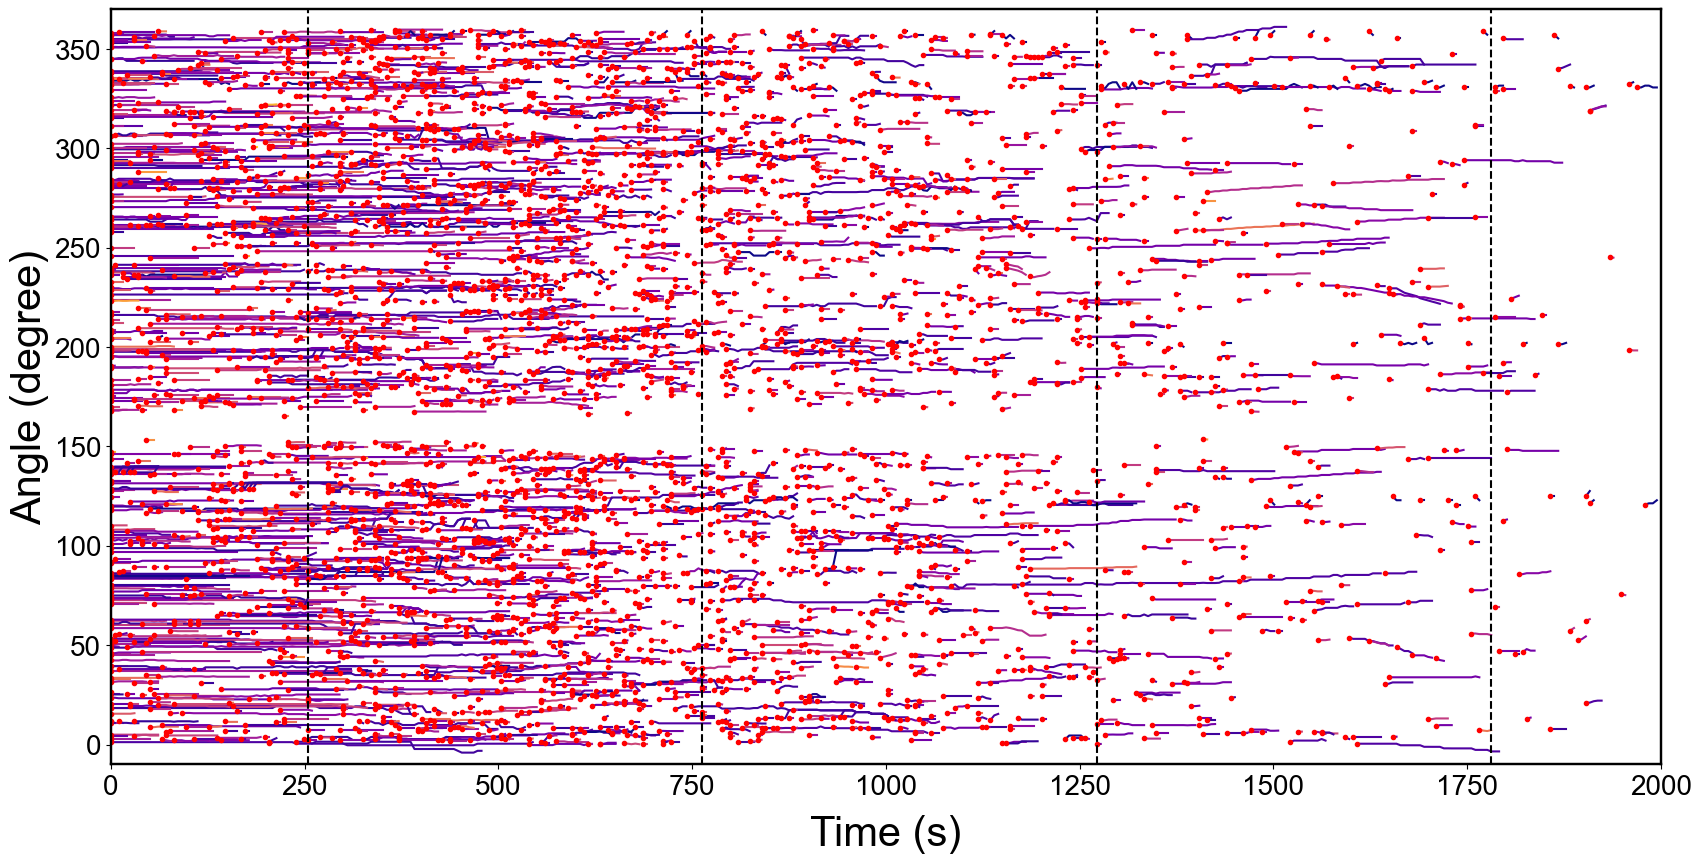

In [42]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

plt.rcParams['axes.linewidth'] = 1.75
fs = np.arange(0,len(images))
r_max = np.max(rs_mean)
r_min = np.min(rs_mean)
f = plt.figure(num=None, figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
ax = f.add_subplot(111)
rs_var_mean = np.mean(rs_var)
plasma = plt.cm.get_cmap('plasma',int(r_max-r_min))
#plt.yticks(rings,ring_string)
#for i in range(len(rings)):
    
    #plt.plot(fs, [rings[i]]*len(fs),'k--')

analyze_angles_spots = []
    
for i in range(len(rs_mean)):
    if (frames[i][1] - frames[i][0]) > 1 and (np.max(rs[i])-np.min(rs[i]))<=2:
        color = plasma((rs_mean[i]-r_min)/(r_max - r_min))[0:3]
        plt.plot(np.multiply(np.arange(frames[i][0],frames[i][1]),2000/393), angles[i], color = color)
        plt.plot(frames[i][0]/393*2000,angles[i][0], 'r.')
        
        analyze_angles_spots.append(i)
#plt.axvline(x=98,color="black", linestyle="--")
plt.axvline(x=50/393*2000,color="black", linestyle="--")
plt.axvline(x=150/393*2000,color="black", linestyle="--")
plt.axvline(x=250/393*2000,color="black", linestyle="--")
plt.axvline(x=350/393*2000,color="black", linestyle="--")
ax.set_ylim([-10,370])
ax.set_xlim([0,2000])
ax.xaxis.set_ticks([0,250,500,750,1000,1250,1500,1750,2000])
#plt.grid(True,alpha=0.3)
plt.xlabel("Time (s)",fontsize=30,labelpad=10) 
plt.ylabel("Angle (degree)",fontsize=30) 
plt.show()

(-0.5, 511.5, 507.5, -0.5)

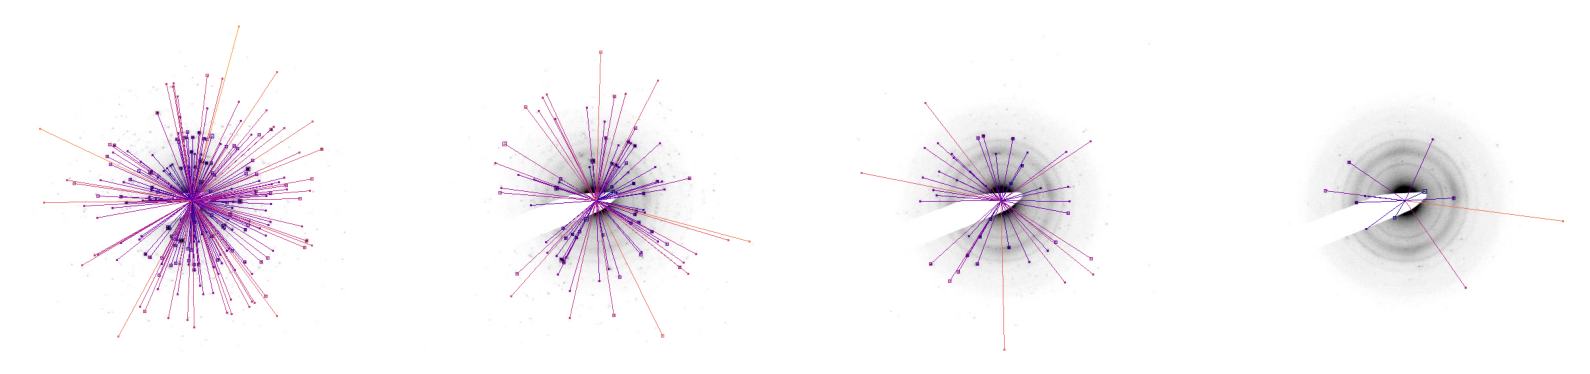

In [45]:
indexes = [50,150,250,350]
bar_region = (470,2,504,79)
h1, w1, h2, w2 = bar_region
fig = plt.figure(figsize=(10, 10), dpi=200)

display_images = []
for ind in range(4):
    frame_index = indexes[ind]
    display_image = cv.cvtColor(images[frame_index], cv.COLOR_GRAY2BGR)
    display_image[h1:h2, w1:w2, :] = 0
    display_image = 255 - display_image

    for i in range(len(bboxes)):
        frame_start = frames[i][0]
        frame_end = frames[i][1]
        if frame_index >= frame_start and frame_index < frame_end:
            color = plasma((rs_mean[i]-r_min)/(r_max - r_min))[0:3]
            y,x,y_len,x_len = tuple(map(float, bboxes[i][frame_index - frame_start].split(', ')))
            cv.rectangle(display_image, (int(x+0.5), int(y+0.5)), (int(x+x_len+0.5), int(y+y_len+0.5)), np.multiply(color,256), 1)
            # draw center
            cv.circle(display_image,(int(center_x+0.5),int(center_y+0.5)),1,(0,0,255),-1)
            # draw line
            vis_lines = []
            line = np.int32(np.array([center_x, center_y, x+x_len/2, y+y_len/2]).T.reshape(2,2) + 0.5)
            vis_lines.append(line)
            cv.polylines(display_image, vis_lines, 0, np.multiply(color,256))
    display_images.append(display_image)
ax1 = fig.add_subplot(141)
ax1.imshow(display_images[0])
ax1.axis('off')
ax2 = fig.add_subplot(142)
ax2.imshow(display_images[1])
ax2.axis('off')
ax3 = fig.add_subplot(143)
ax3.imshow(display_images[2])
ax3.axis('off')
ax4 = fig.add_subplot(144)
ax4.imshow(display_images[3])
ax4.axis('off')

# 8. Ring Indexing Results

## 8.1 Clustering method

In [43]:
def ring_gen_clustering(rs, densities, frames, frame_index):
    from sklearn.cluster import KMeans
    r_frame = []
    density_frame = []
    total_number = len(frames)
    for i in range(total_number):
        frame_start, frame_end = frames[i]
        if frame_index >= frame_start and frame_index < frame_end:
            r_frame.append(rs[i][frame_index - frame_start])
            density_frame.append(densities[i][frame_index - frame_start]/(256))
            
    if len(r_frame) > 50:
        n_clusters = 50
    else:
        if len(r_frame) > 30:
            n_clusters = 10
        else:
            if len(r_frame) > 10:
                n_clusters = 5
            else:
                n_clusters = len(r_frame)
    db = KMeans(n_clusters=n_clusters, n_init = n_clusters, max_iter = 1500).fit(np.array(r_frame).reshape(-1,1),
                                                                  sample_weight = (np.array(density_frame)).flatten())
    
    # adjust rings using the spots which have the most high intensity
    final_rings = []
    labels = db.labels_
    unique_labels = set(labels)
    for k in unique_labels:
        class_member_mask = np.where(labels == k)
        class_index = np.argsort(np.array(density_frame)[class_member_mask[0]])[::-1][0]
        ring = r_frame[class_member_mask[0][class_index]]
        final_rings.append(ring)
    
    return final_rings, labels

In [44]:
def cal_errs(rings, labels, rs, frames, frame_index):
    bbox_frame = []
    total_number = len(frames)
    r_frame = []
    for i in range(total_number):
        frame_start, frame_end = frames[i]
        if frame_index >= frame_start and frame_index < frame_end:
            r_frame.append(rs[i][frame_index - frame_start])
    errs = np.zeros(len(r_frame))
    for k in range(len(r_frame)):
        label = labels[k]
        ring = rings[label]
        errs[k] = abs(r_frame[k]-ring)
   
    return errs

In [45]:
def draw_ring_results(rings, labels, bboxes, images, frame_index, draw_all = False):
    bbox_frame = []
    total_number = len(bboxes)
    for i in range(total_number):
        frame_start, frame_end = frames[i]
        if frame_index >= frame_start and frame_index < frame_end:
            y,x,y_len,x_len = tuple(map(float, bboxes[i][frame_index - frame_start].split(', ')))
            bbox_frame.append((y,x,y_len,x_len))

    bbox_image = cv.cvtColor(images[frame_index],cv.COLOR_GRAY2BGR)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        else:
            class_member_mask = np.where(labels == k)
            color = np.multiply(col[0:3],256)
            color = tuple(color)
            for i in range(len(class_member_mask[0])):
                y,x,y_len,x_len = bbox_frame[class_member_mask[0][i]] 
                point1 = [int(x+0.5), int(y+0.5)]
                point2 = [int(x+x_len+0.5), int(y+y_len+0.5)]
                cv.rectangle(bbox_image, tuple(point1), tuple(point2), color = tuple(color), thickness = 1)

    ring_image = cv.cvtColor(images[frame_index],cv.COLOR_GRAY2BGR)

    final_ring = rings
    if draw_all:
        for j in range(len(rings)):
            color = np.multiply(colors[j][0:3],256)
            #color = plasma((final_ring[j]-r_min)/(r_max-r_min))[0:3]
            #if j not in display_index:
            cv.circle(ring_image,(int(center_x+0.5),int(center_y+0.5)),int(final_ring[j]+0.5),color,1)
    else:
        for j in range(len(rings)):
            if final_ring[j] < 200:
                color = np.multiply(colors[j][0:3],256)
                #color = plasma((final_ring[j]-r_min)/(r_max-r_min))[0:3]
                #if j not in display_index:
                cv.circle(ring_image,(int(center_x+0.5),int(center_y+0.5)),int(final_ring[j]+0.5),color,1)
    return bbox_image, ring_image

In [46]:
def correct_image(image,theta,a,b,center):
    center_x, center_y = center
    h,w = image.shape
    output = np.zeros_like(image)
    for y in range(h):
        for x in range(w):

            t0 = np.arctan2(y-center_y, x-center_x) - theta
            xn = a*np.cos(theta)*np.cos(t0) - b*np.sin(theta)*np.sin(t0)
            yn = a*np.sin(theta)*np.cos(t0) + b*np.cos(theta)*np.sin(t0)
            scale = min(a,b)/np.sqrt(xn**2+yn**2)

            r = np.sqrt((y-center_y)**2 + (x-center_x)**2)*scale
            #r[index] = np.sqrt((y + y_len/2 - center_y)**2 + (x + x_len/2 - center_x)**2)
            dy = y-center_y
            dx = x-center_x
            angle = np.degrees(np.arctan2(dy,dx)) % 360
#             if index > 0:
#                 if (angle[index - 1] - angle[index]) > 270:
#                     angle[index] = angle[index] + 360
#                 if (angle[index] - angle[index - 1]) > 270:
#                     angle[index] = angle[index] - 360
            new_y = r*np.sin(np.radians(angle))+center_y
            new_x = r*np.cos(np.radians(angle))+center_x
            new_y = max(0,min(h-1,new_y))
            new_x = max(0,min(w-1,new_x))
            output[int(new_y+0.5),int(new_x+0.5)] = image[y,x]
#             print(x,y)
#             print(new_x,new_y)
    return output

0.5052299152389751


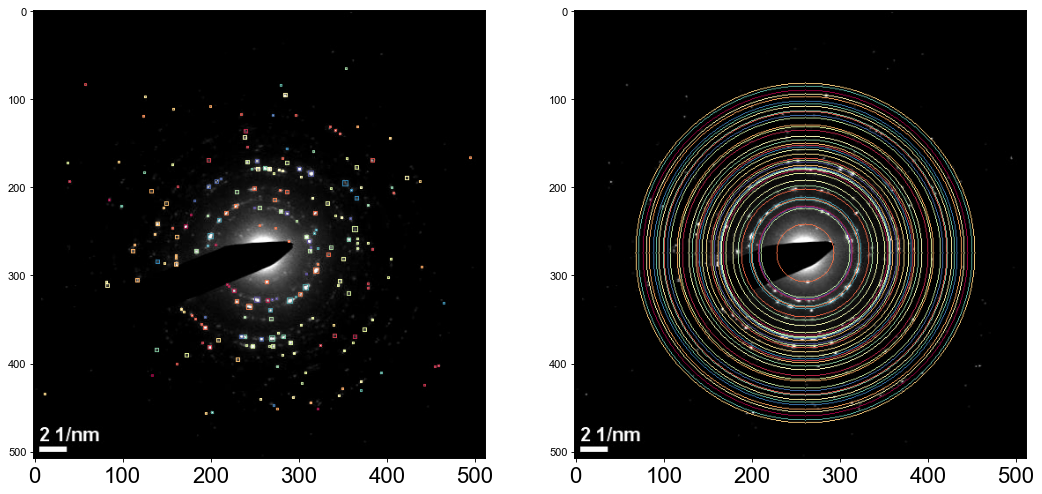

In [47]:
import matplotlib.pyplot as plt
frame_index = 0
ring0,labels0 = ring_gen_clustering(rs, densities, frames, frame_index)
bbox_image, ring_image = draw_ring_results(ring0, labels0, bboxes, images, frame_index)
errs0 = cal_errs(ring0, labels0, rs, frames, frame_index)
print(np.mean(errs0))
plt.rc('ytick', labelsize=10)
plt.figure(num=None, figsize=(16,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(bbox_image)
plt.subplot(122)
plt.imshow(ring_image)

In [48]:
video_rings = []
video_labels = []
for i in range(len(images)):
    ring0,labels0 = ring_gen_clustering(rs, densities, frames, i)
    #bbox_image, ring_image = draw_ring_results(ring0, labels0, bboxes, images, i)
    video_rings.append(ring0)
    video_labels.append(labels0)

<ipython-input-43-d0f3a5c96eb1>:22: ConvergenceWarning: Number of distinct clusters (47) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  db = KMeans(n_clusters=n_clusters, n_init = n_clusters, max_iter = 1500).fit(np.array(r_frame).reshape(-1,1),
<ipython-input-43-d0f3a5c96eb1>:22: ConvergenceWarning: Number of distinct clusters (47) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  db = KMeans(n_clusters=n_clusters, n_init = n_clusters, max_iter = 1500).fit(np.array(r_frame).reshape(-1,1),
<ipython-input-43-d0f3a5c96eb1>:22: ConvergenceWarning: Number of distinct clusters (49) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  db = KMeans(n_clusters=n_clusters, n_init = n_clusters, max_iter = 1500).fit(np.array(r_frame).reshape(-1,1),


## 8.2 Ring tracking

In [49]:
def frame_ring_distance(ring1, ring2, thre = 1):
    ring1 = np.array(ring1)
    ring2 = np.array(ring2)
    num1 = len(ring1)
    num2 = len(ring2)
    distance_matrix = np.zeros((num1,num2))
    ring1_matrix = np.tile(ring1.reshape(-1,1),(1, num2))
    ring2_matrix = np.tile(ring2.reshape(1,-1),(num1,1))
    distance_matrix = np.abs(np.subtract(ring1_matrix, ring2_matrix))
    
    one2two = np.argmin(distance_matrix, axis = 1).flatten()
    two2one = np.argmin(distance_matrix, axis = 0).flatten()
    
    same_index = np.zeros_like(one2two) - 1
    for i in range(len(one2two)):
        if two2one[one2two[i]] == i and distance_matrix[i,one2two[i]] <= thre:
            same_index[i] = one2two[i]
    
    return same_index

In [50]:
for i in range(len(video_rings)):
    video_rings[i] = np.sort(video_rings[i])
ring_tracking_index = []
for i in range(len(video_rings) - 1):
    frame_ring1 = video_rings[i]
    frame_ring2 = video_rings[i + 1]
    ring_index = frame_ring_distance(frame_ring1, frame_ring2)
    ring_tracking_index.append(ring_index)
ring_tracks_matrix = []# 0 is out of track, 1 is in track, -1 is the end of track
for i in range(len(video_rings)):
    ring_tracks_matrix.append(np.zeros(len(video_rings[i])))

ring_tracks = []
time_tracks = []
for f in range(len(ring_tracking_index)):
    end_track_index = np.where(ring_tracking_index[f] == -1)
    if len(end_track_index) > 0:
        ring_tracks_matrix[f][end_track_index] = -1
    for i in range(len(ring_tracking_index[f])):
        if ring_tracking_index[f][i] is not -1 and ring_tracks_matrix[f][i] == 0:
            track = []
            track.append(i)
            ring_tracks_matrix[f][i] = 1
            next_index = ring_tracking_index[f][i]
            track.append(next_index)
            ring_tracks_matrix[f+1][next_index] = 1
            pre_len = len(ring_tracks)
            for t_f in range(f+1, len(ring_tracking_index)):
                if ring_tracking_index[t_f][next_index] == -1:
                    time_tracks.append([f,t_f])
                    ring_tracks.append(np.array(track))
                    ring_tracks_matrix[t_f][next_index] = -1
                    break
                else:
                    new_index = ring_tracking_index[t_f][next_index]
                    next_index = new_index
                    track.append(next_index)
                    ring_tracks_matrix[t_f+1][next_index] = 1
            after_len = len(ring_tracks)
            if pre_len == after_len:
                time_tracks.append([f,len(ring_tracking_index)])
                ring_tracks.append(track)

<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-50-6af97b0815b2>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if ring_tracking_index[f][i] is not -1 and ring_tracks_matrix[f][i] == 0:


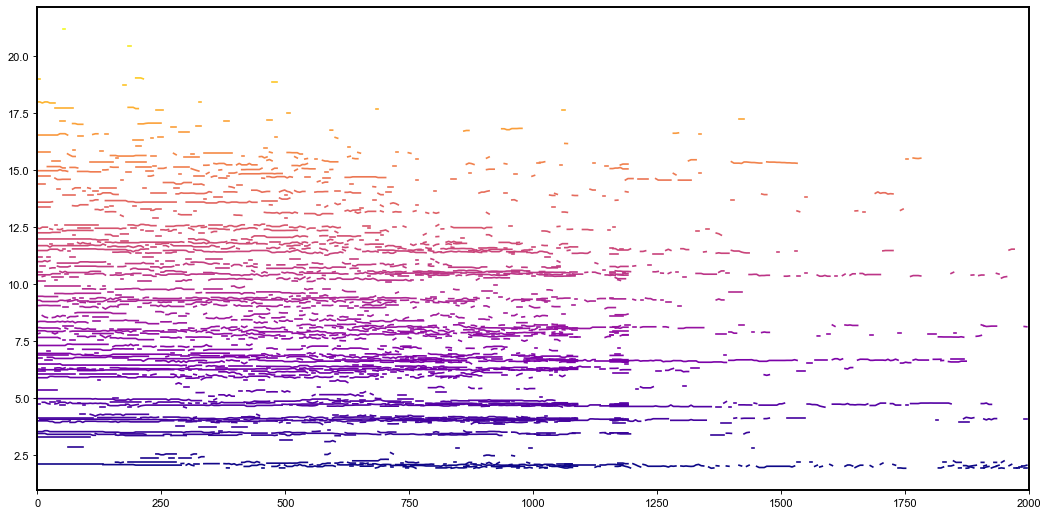

In [51]:
plt.figure(num=None, figsize=(16,8), dpi=80, facecolor='w', edgecolor='k')
plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)
valid_means = np.zeros(len(ring_tracks))

valid_rings = []

for i in range(len(ring_tracks)):
    one_track = np.zeros(len(ring_tracks[i]))
    for j in range(len(ring_tracks[i])):
        one_track[j] = video_rings[time_tracks[i][0]+j][ring_tracks[i][j]]
    valid_rings.append(one_track)
    valid_means[i] = np.mean(one_track)
max_val = np.max(valid_means)
min_val = np.min(valid_means)
colors = plt.cm.get_cmap('plasma', int(max_val - min_val))
for i in range(len(valid_rings)):
    one_track = valid_rings[i]
    plt.plot(np.multiply(np.arange(time_tracks[i][0],time_tracks[i][1]+1),2000/393),one_track*0.0645, c = colors((valid_means[i]-min_val)/(max_val - min_val)))  
plt.xlim([0,2000])
plt.show()

In [52]:
len(valid_rings)

1769

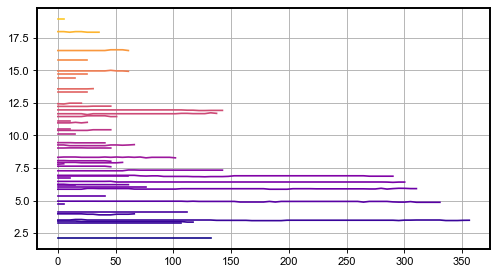

In [53]:
plt.figure(num=None, figsize=(7.3,4), dpi=80, facecolor='w', edgecolor='k')
#colors = [plt.cm.Spectral(each)
#              for each in np.linspace(0, 1, len(ring_tracks))]
colors = plt.cm.get_cmap('plasma', int(max_val - min_val))
for i in range(len(valid_rings)):
    if time_tracks[i][0] == 0:
        #plt.plot(time_tracks[i][0]*2000/393,np.multiply(valid_rings[i][0],0.0645),'r.')
        plt.plot(np.multiply(np.arange(time_tracks[i][0],time_tracks[i][1]+1),2000/393), np.multiply(valid_rings[i],0.0645), c = colors((valid_means[i]-min_val)/(max_val - min_val)))
plt.grid(True)
plt.show()

## 8.3 Illustration of rings indexing results of the first frame

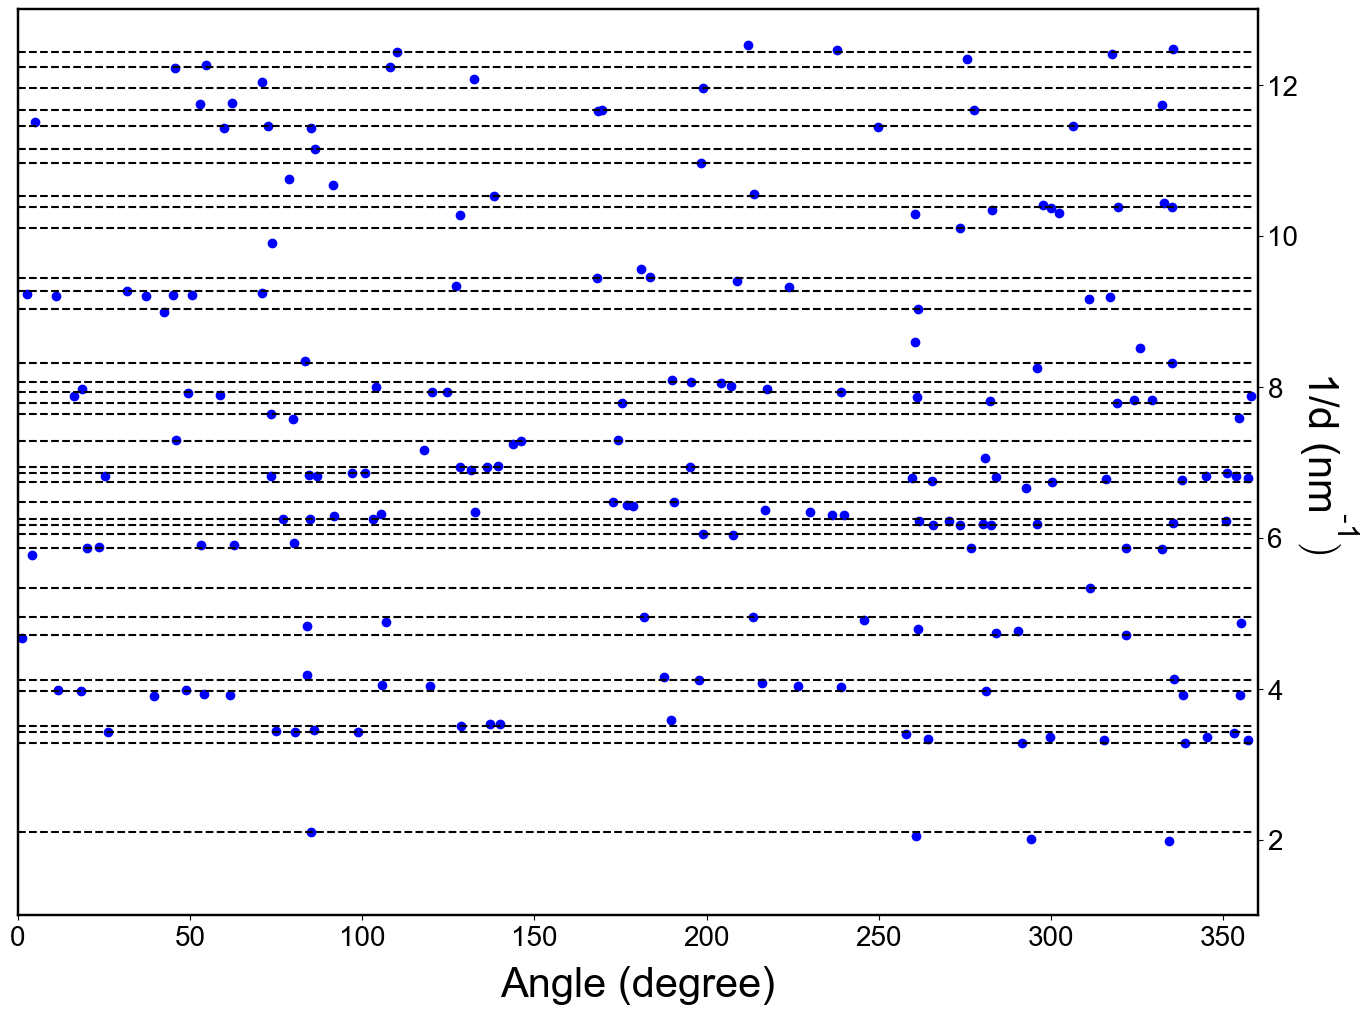

In [56]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
r_frame0 = []
ang_frame0 = []
total_number = len(rs)
frame_index = 0
for i in range(total_number):
    frame_start, frame_end = frames[i]
    if frame_index >= frame_start and frame_index < frame_end:
        r_frame0.append(rs[i][frame_index - frame_start])
        ang_frame0.append(angles[i][frame_index - frame_start])
r_max = max(r_frame0)
r_min = min(r_frame0)
plasma = cm.get_cmap('plasma', int(r_max - r_min))
p = plt.figure(num=None, figsize=(16, 12), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth'] = 1.75
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
axs = p.add_subplot(111)


frame_ring = video_rings[frame_index]
frame_start, frame_end = frames[frame_index]
ring_string = []
new_frame_ring = []
for i in range(len(frame_ring)):
    if ring_tracking_index[frame_index][i] != -1: 
        ring_string.append("{:.3f}".format(frame_ring[i]*0.0645))
        new_frame_ring.append(frame_ring[i])
final_frame_ring = []
final_string = []
for i in range(len(new_frame_ring)):
    final_string.append(ring_string[i])
    final_frame_ring.append(new_frame_ring[i])


#plt.yticks(final_frame_ring,final_string,fontsize = 14)
final_frame_ring = np.sort(final_frame_ring)
for i in range(len(final_frame_ring)):
    plt.plot(np.arange(0,360,360/len(r_frame0)), [final_frame_ring[i]*0.0645]*len(r_frame0),'k--')

plt.scatter(ang_frame0,np.multiply(r_frame0,0.0645), color = 'b')


axs.yaxis.tick_right()
axs.yaxis.set_label_position("right")

axs.set_xlim([0,360])
axs.set_ylim([1,13])

axs.set_ylabel("1/d ($\mathregular{nm^{-1}})$",fontsize=30,rotation=270,labelpad=45,fontname="Arial") 
axs.set_xlabel("Angle (degree)",fontsize=30,labelpad=10,fontname="Arial")



plt.show()

(-0.5, 511.5, 507.5, -0.5)

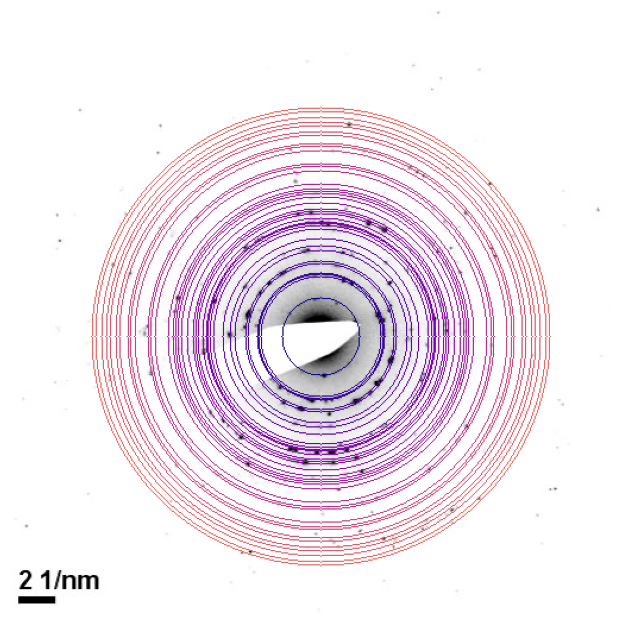

In [57]:
#frame_index = 0
display_image = cv.cvtColor(correct_image(images[frame_index],theta,a,b,(center_x,center_y)),cv.COLOR_GRAY2BGR)
display_image = 255 - display_image
index = np.array(final_frame_ring)<200
final_ring = np.array(final_frame_ring)[index]
plasma = cm.get_cmap('plasma', int(np.max(final_frame_ring) - np.min(final_frame_ring)))
r_max = np.max(final_frame_ring)
r_min = np.min(final_frame_ring)
for j in range(len(final_frame_ring)):
    if final_frame_ring[j] < 200:
        color = plasma((final_frame_ring[j]-r_min)/(r_max-r_min))[0:3]
        #if j not in display_index:
        cv.circle(display_image,(int(center_x+0.5),int(center_y+0.5)),int(final_frame_ring[j]+0.5),np.multiply(color,255),1)
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(display_image)
plt.axis('off')

# 9. Single Diffraction Spots

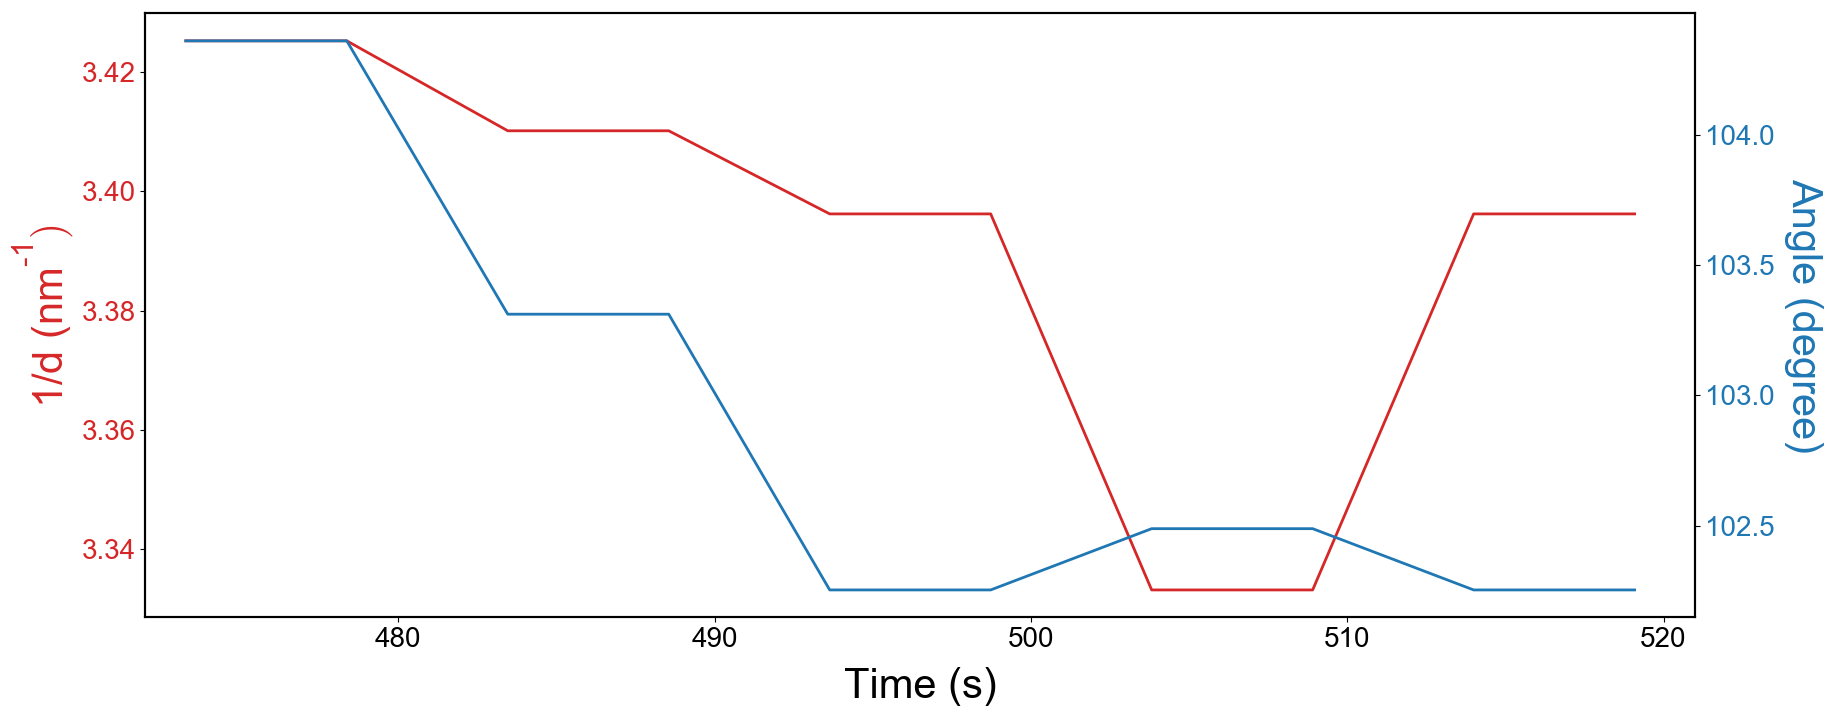

In [53]:
plt.rcParams['font.family'] = 'Arial'

spots_index = 2294
frame_start = frames[spots_index][0]
frame_end = frames[spots_index][1]
new_rs_for_index = rs[spots_index]
f = plt.figure(num=None, figsize=(20, 8), dpi=100, facecolor='w', edgecolor='k')

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.rcParams['axes.linewidth'] = 1.5

color = 'tab:red'
axs = f.add_subplot(111)
axs.set_ylabel("1/d ($\mathregular{nm^{-1}})$", color=color,fontsize=30,fontname="Arial")
axs.plot(np.multiply(np.arange(frame_start,frame_end),2000/393),np.multiply(new_rs_for_index,0.0645),color=color,linewidth=2)
#axs.yaxis.tick_left()
axs.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2 = axs.twinx()
ax2.set_ylabel("Angle (degree)", color=color,fontsize=30,rotation=270,labelpad=35,fontname="Arial")
ax2.plot(np.multiply(np.arange(frame_start,frame_end),2000/393),angles[spots_index],color=color,linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
#plt.scatter(ang_frame0,np.multiply(r_frame0,0.0645), color = 'b')



axs.set_xlim([472,521])#2294
#axs.set_xlim([518,617]) #2641
#axs.xaxis.set_ticks([520,525,530,535,540,545,550,555,560,565,570,575,580,585,590,595,600,605,610,615])#2641
#axs.set_xlim([1388,1518])#6704
#axs.xaxis.set_ticks([1390,1400,1410,1420,1430,1440,1450,1460,1470,1480,1490,1500,1510])#6704
axs.set_xlabel("Time (s)",fontsize=30,labelpad=10,fontname="Arial")


plt.show()

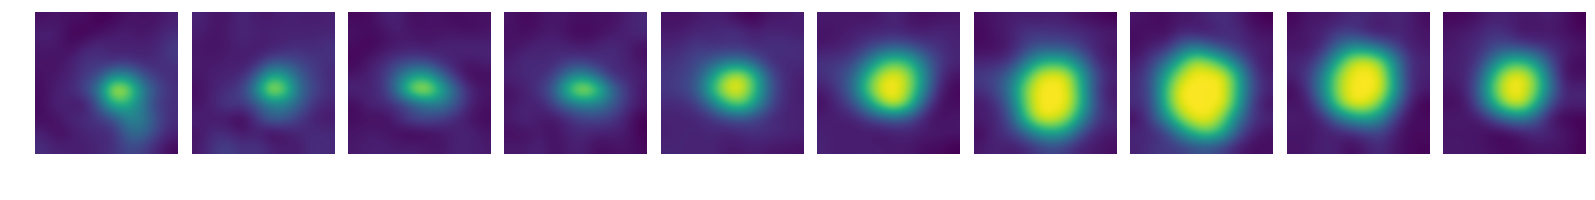

In [54]:
from matplotlib import gridspec

frame_start = frames[spots_index][0]
frame_end = frames[spots_index][1]

fig, ax = plt.subplots(nrows=1, ncols=int(frame_end-frame_start), figsize=(20, 2), dpi=100, sharex=True, sharey=True)

show_size = 10
spots_rs = []
for i in range(frame_start,frame_end):
    #axs = f.add_subplot(1,10,(i - frame_start+1))
    y,x,y_len,x_len = tuple(map(float, bboxes[spots_index][i - frame_start].split(', ')))
    spots_rs.append(y_len)
    test_image = images[i]

    new_y = y+y_len/2-show_size/2
    new_x = x + x_len/2 - show_size/2
    
    ax[i - frame_start].imshow(images[i][int(new_y+0.5):int(new_y+show_size+0.5),int(new_x+0.5):int(new_x+show_size+0.5)],interpolation='bicubic', cmap='viridis')
    ax[i - frame_start].axis('off')

plt.subplots_adjust(wspace=0.1)

plt.show()